# <ins>Fuel Efficiency of Canadian Vehicles<ins>
> # Econ 323 Final Project

A Project By:
| Name | Student Number | Section |
|------|----------------|---------|
| Alexander Proskiw | 27194166 | 003 |
| Kai Groden-Gilchrist | 35600148 | 003 |

# Table Of Contents

1. Introduction

2. Importing and Cleaning the Data

3. Exploring the Effect Of Each Explanatory Variable In Isolation

    a. Raw effects

    b. Temporal effects

    c. Correlations

    d. General findings

4. Fitting Models
5. R&D Spending
6. Conclusions
7. References

# 1. Introduction

With gasoline prices reaching record highs in 2022 and remaining elevanted since, fuel efficiency is a key concern for consumers looking to buy a vehicle. 

The goal of this research project is to explore fuel efficiency of Canadian vehiclesby answering the following questions:
- Has vehicle fuel efficiency improved from 2000 to 2023?
- Which manufacturer produces, on average, the most fuel efficient vehicles?
- Can existing fuel efficiency information be used to predict the fuel efficiency of future vehicles?
- Are changes in fuel efficiency for a manufacturer related to R&D spending?

The dataset chosen for this project is the [Natural Resources Canada Fuel Consumption Ratings Dataset](https://open.canada.ca/data/en/dataset/98f1a129-f628-4ce4-b24d-6f16bf24dd64?fbclid=IwAR1rVpyNw3KJSeAcT6ryyCAADAnmB7uDtujvwlswFkOzaiLlnjIt29EekiY), which includes fuel consumption information for vehicles sold in Canada from 2000 to 2023, along with supporting information about each vehicle such as maked, model, vehicle type, engine size, transmission type for each vehicle.

# 2. Importing and Cleaning the Data

This section involves importing, combining, and cleaning the fuel consumption datasets. 

Section 2.1 imports all the libraries and packages used in this investigation.

Section 2.2 reads in the datasets from csv files, and combines them into one pandas DataFrame.

Section 2.3 cleans the DataFrame for future manipulation. 

Section 2.4 gives an initial overview of the data and how it will be used.

## 2.1 Required Import Statements

We begin by importing all python packages that will be utilized in this project, as well as setting some custom figure display and text output options.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import patsy
import tabula
from plotly import express as px, graph_objs as go
from sklearn import (linear_model, metrics, tree, model_selection, neural_network, preprocessing, pipeline)
from sklearn.model_selection import cross_val_score
from itertools import cycle
from datetime import datetime
pd.set_option('display.max_rows', 100)
sns.set_palette("muted")
sns.set_style("darkgrid")
%matplotlib inline 

## 2.2 Read and Concatenate the Data

Next we read in the csv files from the Natural Resources Canada Database, specifically the aggregated files for 2000-2004, 2005-2009, and 2010-2014, as well as the yearly files from 2015 to 2023.

In [2]:
fuel_cons_2023 = pd.read_csv("https://www.nrcan.gc.ca/sites/nrcan/files/oee/files/csv/MY2023%20Fuel%20Consumption"
                             + "%20Ratings.csv", encoding="Windows-1252", low_memory=False)
fuel_cons_2022 = pd.read_csv("https://www.nrcan.gc.ca/sites/nrcan/files/oee/files/csv/MY2022%20Fuel%20Consumption"
                             + "%20Ratings.csv", encoding="Windows-1252", low_memory=False)
fuel_cons_2021 = pd.read_csv("https://www.nrcan.gc.ca/sites/nrcan/files/oee/files/csv/MY2021%20Fuel%20Consumption"
                             + "%20Ratings.csv", encoding="Windows-1252", low_memory=False)
fuel_cons_2020 = pd.read_csv("https://www.nrcan.gc.ca/sites/nrcan/files/oee/files/csv/MY2020%20Fuel%20Consumption"
                             + "%20Ratings.csv", encoding="Windows-1252", low_memory=False)
fuel_cons_2019 = pd.read_csv("https://www.nrcan.gc.ca/sites/nrcan/files/oee/files/csv/MY2019%20Fuel%20Consumption"
                             + "%20Ratings.csv", encoding="Windows-1252", low_memory=False)
fuel_cons_2018 = pd.read_csv("https://www.nrcan.gc.ca/sites/nrcan/files/oee/files/csv/MY2018%20Fuel%20Consumption"
                             + "%20Ratings.csv", encoding="Windows-1252", low_memory=False)
fuel_cons_2017 = pd.read_csv("https://www.nrcan.gc.ca/sites/nrcan/files/oee/files/csv/MY2017%20Fuel%20Consumption"
                             + "%20Ratings.csv", encoding="Windows-1252", low_memory=False)
fuel_cons_2016 = pd.read_csv("https://www.nrcan.gc.ca/sites/nrcan/files/oee/files/csv/MY2016%20Fuel%20Consumption"
                             + "%20Ratings.csv", encoding="Windows-1252", low_memory=False)
fuel_cons_2015 = pd.read_csv("https://www.nrcan.gc.ca/sites/nrcan/files/oee/files/csv/MY2015%20Fuel%20Consumption"
                             + "%20Ratings.csv", encoding="Windows-1252", low_memory=False)
fuel_cons_2010_2014 = pd.read_csv("https://www.nrcan.gc.ca/sites/www.rncan.gc.ca/files/oee/files/csv/MY2010-2014"
                             + "%20Fuel%20Consumption%20Ratings%205-cycle.csv", encoding="Windows-1252", 
                                  low_memory=False)
fuel_cons_2005_2009 = pd.read_csv("https://www.nrcan.gc.ca/sites/www.rncan.gc.ca/files/oee/files/csv/MY2005-2009"
                             + "%20Fuel%20Consumption%20Ratings%205-cycle.csv", encoding="Windows-1252", 
                                  low_memory=False)
fuel_cons_2000_2004 = pd.read_csv("https://www.nrcan.gc.ca/sites/www.rncan.gc.ca/files/oee/files/csv/MY2000-2004"
                             + "%20Fuel%20Consumption%20Ratings%205-cycle.csv", encoding="Windows-1252", 
                                  low_memory=False)

Next we combine the individual datasets into a single dataset. 

This includes removing rows with NA values, and dropping certain non-data rows at the bottom of each spreadsheet.

In [3]:
# drop nas and combine datasets from each year
list_of_fuel_data = [fuel_cons_2023, fuel_cons_2022, fuel_cons_2021, fuel_cons_2020, fuel_cons_2019,
                    fuel_cons_2018, fuel_cons_2017, fuel_cons_2016, fuel_cons_2015, fuel_cons_2010_2014,
                    fuel_cons_2005_2009, fuel_cons_2000_2004]

col_names = ["model_year", "make", "model", "vehicle_class", "engine_size_L", "cylinders", "transmission", 
             "fuel_type", "city_fuel_cons", "hwy_fuel_cons", "comb_lpkm", "comb_mpg", "co2_emissions", 
             "co2_rating","smog_rating"]

for i, dataset in enumerate(list_of_fuel_data):
    # drop rows of entirely NaN, then cols of entirely NaN, then rows with some NaN
    # there was ~50 rows at the bottom with text explaining the data, hence the need for the last drop
    dataset = dataset.dropna(axis=0, how='all').dropna(axis=1, how='all').dropna(axis=0)
    try: 
        dataset.columns = col_names
    # older datasets are missing the last one or two cols
    except ValueError:
        try: 
            dataset.columns = col_names[:-1]
        except ValueError:
            dataset.columns = col_names[:-2]
    list_of_fuel_data[i] = dataset
            
full_dataset = pd.DataFrame()

for dataset in list_of_fuel_data:
    full_dataset = pd.concat([full_dataset, dataset], axis=0)
    
full_dataset.reset_index(drop=True, inplace=True)

The original csv files contain data on the city, highway, and combined (55% city, 45% highway) fuel economy for each vehicle. For the purposes of this research project, <ins>the combined fuel economy (in L/100 km) is going to be our response variable</ins> so as to get a broad representation of each vehicle's efficiency. 

Hence, after concatenating the individual datasets, we can drop the following unnecessary columns:
- City fuel consumption and highway fuel consumption, as the combined fuel consumption represents their weighted average.
- Combined fuel economy in miles per gallon, as this is just a unit conversion from L/100 km
- CO2 emissions, CO2 rating, and Smog rating, as this research project is focusing on fuel efficiency and not emissions or smog

In [4]:
# drop unnecessary columns
full_dataset.drop(["city_fuel_cons", "hwy_fuel_cons", "comb_mpg", "co2_emissions", "co2_rating", "smog_rating"], 
                  axis=1, inplace=True)
# preview the dataset
full_dataset

model_year   make                model             vehicle_class  \
0           2023  Acura              Integra                 Full-size   
1           2023  Acura       Integra A-SPEC                 Full-size   
2           2023  Acura       Integra A-SPEC                 Full-size   
3           2023  Acura           MDX SH-AWD                SUV: Small   
4           2023  Acura    MDX SH-AWD Type S             SUV: Standard   
...          ...    ...                  ...                       ...   
23477       2004  VOLVO         V70 T5 TURBO  STATION WAGON - MID-SIZE   
23478       2004  VOLVO         V70 T5 TURBO  STATION WAGON - MID-SIZE   
23479       2004  VOLVO       XC70 AWD TURBO                       SUV   
23480       2004  VOLVO  XC90 2.5T AWD TURBO                       SUV   
23481       2004  VOLVO    XC90 T6 AWD TURBO                       SUV   

      engine_size_L  cylinders transmission fuel_type comb_lpkm  
0               1.5        4.0          AV7         Z       7.2  
1               1.5        4.0          AV7         Z       7.4  
2               1.5        4.0           M6         Z       7.8  
3               3.5        6.0         AS10         Z      11.2  
4               3.0        6.0         AS10         Z      12.4  
...             ...        ...          ...       ...       ...  
23477           2.3        5.0          AS5         Z      12.5  
23478           2.3        5.0           M5         Z      11.8  
23479           2.5        5.0          AS5         Z      12.5  
23480           2.5        5.0          AS5         Z      13.0  
23481           2.9        6.0          AS5         Z      15.1  

[23482 rows x 9 columns]

From above we get our first look at the dataset

Immediately we note that several of the rows have somewhat confusing information. For example, fuel type seems to just be a letter, transmission is an abbreviation, and vehicle class appears inconsistent, with 3 different labelings for SUVs present in just the first 5 and last 5 rows of the dataset alone.

All of these issues need to be addressed through cleaning of the data.

## 2.3 Cleaning the Data

We start by seeing what our datatypes are:

In [5]:
full_dataset.dtypes

model_year        object
make              object
model             object
vehicle_class     object
engine_size_L     object
cylinders        float64
transmission      object
fuel_type         object
comb_lpkm         object
dtype: object

Aside from cylinders, all datatypes are current;y "object". We need to convert certain columns to numeric data, namely integers for the year and floats for the engine size, and fuel efficiency

In [6]:
# convert appropriate object datatypes to numerical
full_dataset["model_year"] = full_dataset["model_year"].astype(int)
cols = ["engine_size_L", "comb_lpkm"]
full_dataset[cols] = full_dataset[cols].astype(float)
full_dataset.dtypes

model_year         int64
make              object
model             object
vehicle_class     object
engine_size_L    float64
cylinders        float64
transmission      object
fuel_type         object
comb_lpkm        float64
dtype: object

Next we will work on cleaning the vehicle 'make' column

Minor improvements include fixing inconsistent capitalization, and combining "Ram" and "Dodge" into a single brand.

More importantly, we remove any rows associated with manufacturers that didn't produce at least one vehicle in every year from 2000 to 2023. This step is implemented because we want to assess fuel efficiency changes over the entire 2000-2023 time period. If a company went bankrupt in the early 2000's, or if a company was founded in the late 2010's, their fuel economy data could potentially skew the results.

In [7]:
# clean the 'make' series

# different capitalizations of makes were used in different years. Update for consistency.
full_dataset["make"] = full_dataset["make"].str.title()

# also adjust to account for Dodge rebranding their pickup trucks under the Ram name
full_dataset["make"].replace({"Ram": "Dodge"}, inplace = True)

# remove data from the datset for manufacturers that didn't make cars from 2000 to 2023
makes = full_dataset.groupby("make")
for make in makes.groups:
    matches_make = (full_dataset["make"] == make)
    only_current_make_dataset = full_dataset[matches_make]
    num_years = only_current_make_dataset["model_year"].nunique()
    not_full_range_of_years = (num_years != 24)
    if not_full_range_of_years:
        full_dataset.drop(only_current_make_dataset.index, inplace=True)
full_dataset.reset_index(drop=True, inplace=True)

# verify changes
print(full_dataset["make"].unique())

['Acura' 'Audi' 'Bmw' 'Buick' 'Cadillac' 'Chevrolet' 'Chrysler' 'Dodge'
 'Ford' 'Gmc' 'Honda' 'Hyundai' 'Infiniti' 'Jaguar' 'Jeep' 'Kia' 'Lexus'
 'Lincoln' 'Mazda' 'Mercedes-Benz' 'Nissan' 'Subaru' 'Toyota' 'Volkswagen'
 'Volvo']


Upon cleaning the vehicle make column, we see that we have 25 different manufacturers from around the globe.

Next is to clean the vehicle class column.

For simplicity, we reduce the various sub-categories into 4:
- Car
- SUV
- Truck
- Van

Passenger/cargo vans were removed from the dataset at this stage, as they are typically used as business vehicles (e.g., as an Amazon delivery van) rather than by typical consumers, who are the focus of this study.

In [8]:
# clean the 'vehicle_class' series

# we are going to simplify into 5 categories: Car, SUV, Van, Truck, and Passenger/Cargo Van
full_dataset["vehicle_class"].replace({"Full-size": "Car",
                                       "SUV: Small": "SUV",
                                       "SUV: Standard": "SUV",
                                       "Compact": "Car",
                                       "Subcompact": "Car",
                                       "Station wagon: Small": "Car",
                                       "Mid-size": "Car",
                                       "Station wagon: Mid-size": "Car",
                                       "Two-seater": "Car",
                                       "Pickup truck: Standard": "Truck",
                                       "Minivan": "Van",
                                       "Pickup truck: Small": "Truck",
                                       "Special purpose vehicle": "Passenger/Cargo Van",
                                       "Minicompact": "Car",
                                       "Van: Passenger": "Passenger/Cargo Van",
                                       "COMPACT": "Car",
                                       "SUV - SMALL": "SUV",
                                       "TWO-SEATER": "Car",
                                       "MID-SIZE": "Car",
                                       "SUBCOMPACT": "Car",
                                       "STATION WAGON - SMALL": "Car",
                                       "FULL-SIZE": "Car",
                                       "SUV - STANDARD": "SUV",
                                       "SPECIAL PURPOSE VEHICLE": "Van",
                                       "PICKUP TRUCK - SMALL": "Truck",
                                       "VAN - PASSENGER": "Passenger/Cargo Van",
                                       "PICKUP TRUCK - STANDARD": "Truck",
                                       "MINIVAN": "Van",
                                       "STATION WAGON - MID-SIZE": "Car",
                                       "MINICOMPACT": "Car",
                                       "SUV": "SUV",
                                       "VAN - CARGO": "Passenger/Cargo Van",
                                       "UL": "SUV"}, inplace = True)

# remove the passenger/cargo van category as these are typically business vehicles
is_passenger_cargo_van = full_dataset["vehicle_class"] == "Passenger/Cargo Van"
only_passenger_cargo_van_dataset = full_dataset[is_passenger_cargo_van]
full_dataset.drop(only_passenger_cargo_van_dataset.index, inplace=True)
full_dataset.reset_index(drop=True, inplace=True)

# verify changes
print(full_dataset["vehicle_class"].unique())

['Car' 'SUV' 'Truck' 'Van']


Next is to clean the fuel type column. Using [the information from Natural Resource Canada](https://natural-resources.canada.ca/energy-efficiency/transportation-alternative-fuels/personal-vehicles/choosing-right-vehicle/buying-electric-vehicle/understanding-the-tables/21383), we can change the single letter codes into 5 different fuel types:
- Regular Gasoline
- Premium Gasoline
- Diesel
- Ethanol
- Natural Gas

In [9]:
# clean the 'fuel_type' series

# update the fuel types from letters to their actual meanings
full_dataset["fuel_type"].replace({"X": "Regular Gasoline",
                                   "Z": "Premium Gasoline",
                                   "D": "Diesel",
                                   "E": "Ethanol",
                                   "N": "Natural Gas"}, inplace = True)

# verify changes
print(full_dataset["fuel_type"].unique())

['Premium Gasoline' 'Regular Gasoline' 'Diesel' 'Ethanol' 'Natural Gas']


Next is to clean the transmission column. This is achieved by separating the alphanumeric abbreviation into two separate columns - one for the transmission type and one for the number of gears. Transmission types include:
- Automatic
- Automated Manual
- Automatic Select Shift
- Continuously Variable
- Manual

Note that for the number of gears, Continuously Variable transmissions have been assigned as having 1 gear.

In [10]:
# clean the 'transmission' series

# separate each into the transmission type and gears
def convert_transmission_to_type(s):
    transmission_type = re.findall('([A-Za-z]+)', s)
    return transmission_type[0]

def convert_transmission_to_gears(s):
    transmission_gears = re.findall('\d+', s)
    if (transmission_gears == []):
        transmission_gears = [1]  
    return transmission_gears[0]

# separate the transmission column into separate columns for transmission type and gears, remove original column
full_dataset["transmission_type"] = full_dataset["transmission"].apply(convert_transmission_to_type)
full_dataset["transmission_gears"] = full_dataset["transmission"].apply(convert_transmission_to_gears)
full_dataset["transmission_gears"] = full_dataset["transmission_gears"].astype(int)
full_dataset.drop(["transmission"], axis=1, inplace=True)

# update the transmission types from abbreviations to their actual meanings
full_dataset["transmission_type"].replace({"A": "Automatic",
                                           "AM": "Automated Manual",
                                           "AS": "Automatic Select Shift",
                                           "AV": "Continuously Variable",
                                           "M": "Manual",}, inplace = True)

# verify changes
full_dataset

model_year   make                model vehicle_class  engine_size_L  \
0            2023  Acura              Integra           Car            1.5   
1            2023  Acura       Integra A-SPEC           Car            1.5   
2            2023  Acura       Integra A-SPEC           Car            1.5   
3            2023  Acura           MDX SH-AWD           SUV            3.5   
4            2023  Acura    MDX SH-AWD Type S           SUV            3.0   
...           ...    ...                  ...           ...            ...   
18933        2004  Volvo         V70 T5 TURBO           Car            2.3   
18934        2004  Volvo         V70 T5 TURBO           Car            2.3   
18935        2004  Volvo       XC70 AWD TURBO           SUV            2.5   
18936        2004  Volvo  XC90 2.5T AWD TURBO           SUV            2.5   
18937        2004  Volvo    XC90 T6 AWD TURBO           SUV            2.9   

       cylinders         fuel_type  comb_lpkm       transmission_type  \
0            4.0  Premium Gasoline        7.2   Continuously Variable   
1            4.0  Premium Gasoline        7.4   Continuously Variable   
2            4.0  Premium Gasoline        7.8                  Manual   
3            6.0  Premium Gasoline       11.2  Automatic Select Shift   
4            6.0  Premium Gasoline       12.4  Automatic Select Shift   
...          ...               ...        ...                     ...   
18933        5.0  Premium Gasoline       12.5  Automatic Select Shift   
18934        5.0  Premium Gasoline       11.8                  Manual   
18935        5.0  Premium Gasoline       12.5  Automatic Select Shift   
18936        5.0  Premium Gasoline       13.0  Automatic Select Shift   
18937        6.0  Premium Gasoline       15.1  Automatic Select Shift   

       transmission_gears  
0                       7  
1                       7  
2                       6  
3                      10  
4                      10  
...                   ...  
18933                   5  
18934                   5  
18935                   5  
18936                   5  
18937                   5  

[18938 rows x 10 columns]

Finally we reorder the columns intuitively.

In [11]:
# reorder the columns
full_dataset = full_dataset[["model_year", "make", "model", "vehicle_class", "fuel_type",
                             "engine_size_L", "cylinders", "transmission_type", 
                             "transmission_gears", "comb_lpkm"]]

# verify changes
full_dataset

model_year   make                model vehicle_class         fuel_type  \
0            2023  Acura              Integra           Car  Premium Gasoline   
1            2023  Acura       Integra A-SPEC           Car  Premium Gasoline   
2            2023  Acura       Integra A-SPEC           Car  Premium Gasoline   
3            2023  Acura           MDX SH-AWD           SUV  Premium Gasoline   
4            2023  Acura    MDX SH-AWD Type S           SUV  Premium Gasoline   
...           ...    ...                  ...           ...               ...   
18933        2004  Volvo         V70 T5 TURBO           Car  Premium Gasoline   
18934        2004  Volvo         V70 T5 TURBO           Car  Premium Gasoline   
18935        2004  Volvo       XC70 AWD TURBO           SUV  Premium Gasoline   
18936        2004  Volvo  XC90 2.5T AWD TURBO           SUV  Premium Gasoline   
18937        2004  Volvo    XC90 T6 AWD TURBO           SUV  Premium Gasoline   

       engine_size_L  cylinders       transmission_type  transmission_gears  \
0                1.5        4.0   Continuously Variable                   7   
1                1.5        4.0   Continuously Variable                   7   
2                1.5        4.0                  Manual                   6   
3                3.5        6.0  Automatic Select Shift                  10   
4                3.0        6.0  Automatic Select Shift                  10   
...              ...        ...                     ...                 ...   
18933            2.3        5.0  Automatic Select Shift                   5   
18934            2.3        5.0                  Manual                   5   
18935            2.5        5.0  Automatic Select Shift                   5   
18936            2.5        5.0  Automatic Select Shift                   5   
18937            2.9        6.0  Automatic Select Shift                   5   

       comb_lpkm  
0            7.2  
1            7.4  
2            7.8  
3           11.2  
4           12.4  
...          ...  
18933       12.5  
18934       11.8  
18935       12.5  
18936       13.0  
18937       15.1  

[18938 rows x 10 columns]

## 2.4 Summary of Dataset

Our cleaned dataset has 18,938 unique entries, each representing a specific vehicle. The columns represent different variables, broken down as follows:

<ins>Response Variable:</ins>
- The "comb_lpkm" column represents the combined fuel efficiency of each vehicle in liters per 100 kilometers (L/100km). This is a continuous numerical variable.

> **Note that when using L/100km, a smaller number represents a more efficient vehicle. This is the opposite of miles per gallon, where higher numbers are more efficient.**

<ins>Explanatory Variables:</ins>
- The "model_year" column represents the year a vehicle was produced in. This is a continuous numerical variable.
- The "make" column represents the manufacturer of a vehicle. This is a categorical variable.
- The "vehicle_class" column represents whether a vehicle is a car, truck, SUV, or van. This is a categorical variable.
- The "fuel_type" column represents what type of fuel a vehicle uses. This is a categorical variable.
- The "engine_size_L" column represents the size of the engine of a vehicle, in Liters. This is a continuous numerical variable.
- The "cylinders" column represents the number of cylinders of the engine of a vehicle. This is a continuous numerical variable.
- The "transmission_type" column represents the type of transmission of a vehicle. This is a categorical variable.
- The "transmission_gears" column represents the number of gears in the transmission of a vehicle. This is a continuous numerical variable.

<ins>Additional Variable:</ins>
- The "model" column includes the specific name of each vehicle. This column will not be used in any visualization or modelling, but is helpful when determining the most/least efficient vehicles.

# 3. Visualizations

This section presents a set of visualizations aimed at gaining a deeper understanding of vehicle fuel efficiency.

Section 3.1 examines the relationship between each explanatory variable (year, make, vehicle class, fuel type, engine size, cylinders, transmission type, and transmission gears) and fuel efficiency.

Section 3.2 explores how the production year of a vehicle interacts with some of the other explanatory variables.

Section 3.3 takes a closer look at the most efficient vehicles and makes.

## 3.1 Effect of the Explanatory Variables on Fuel Efficiency

### 3.1.1 Model Year

To examine how fuel efficiency varies by year, we've aggregated data across all the vehicles for each year. We plotted three metrics for each year: an average fuel efficiency, along with the 5th and 95th percentiles (representing a 90% confidence interval).

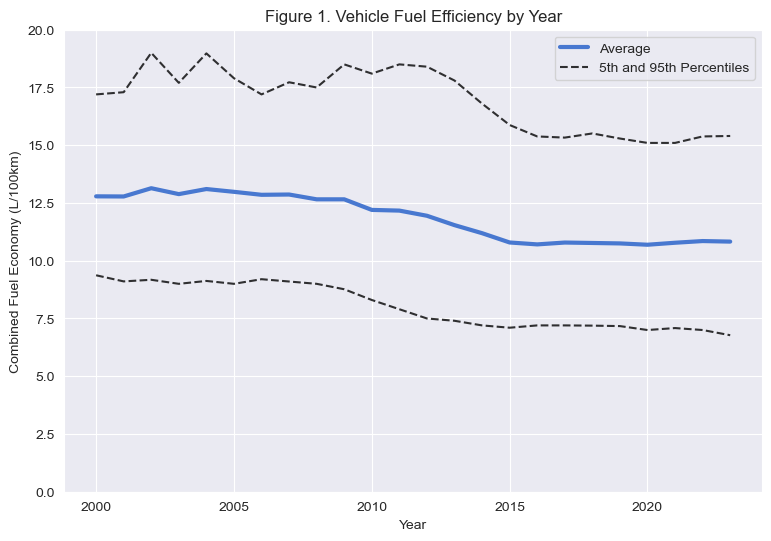

In [12]:
# 5th Percentile
def q05(x):
    return x.quantile(0.05)

# 95th Percentile
def q95(x):
    return x.quantile(0.95)


fuel_economy_by_year = full_dataset.pivot_table(index="model_year", 
                                                values="comb_lpkm", 
                                                aggfunc=["mean", q05, q95])
ax = fuel_economy_by_year.plot()
ax.set_xlabel("Year")
ax.set_ylabel("Combined Fuel Economy (L/100km)")
ax.set_title("Figure 1. Vehicle Fuel Efficiency by Year")
ax.set_ylim(0, 20)
plt.gca().get_lines()[0].set_linewidth(3)
plt.gca().get_lines()[1].set_color("black")
plt.gca().get_lines()[1].set_linestyle("--")
plt.gca().get_lines()[1].set_alpha(0.8)
plt.gca().get_lines()[2].set_color("black")
plt.gca().get_lines()[2].set_linestyle("--")
plt.gca().get_lines()[2].set_alpha(0.8)
ax.legend(['Average', '5th and 95th Percentiles'])
plt.gcf().set_size_inches(9, 6)

The figure above clearly demonstrates a downward trend in the combined fuel economy of vehicles from 2000 to 2023. 

The average fuel economy across all makes and models decreased from approximately 12.8 L/100km in 2000 to 10.8 L/100km in 2023 (approximately 16%). Decreases were also observed for the 5th and 95th percentiles of vehicles. 

However, the improvements in fuel economy do not appear to be uniform. Little change is observed from 2000 to 2010, followed by a large improvement in fuel economy from 2010 to 2015. Since 2015, we observe little change.

While newer cars generally appear to be more fuel-efficient than older models, it will likely be beneficial to analyze each manufacturer individually.

### 3.1.2 Make

To examine how fuel efficiency varies by make, data is aggregated across all the vehicles and years for each make. 

This equates to an average fuel efficiency value for all the vehicles each manufacturer has produced from 2000 to 2023.

A figure showing this average fuel economy for each manufacturer is provided below, ordered from most to least efficicent.

Text(0.5, 1.0, 'Figure 2. Fuel Economy by Different Manufacturers, Averaged Across all Years')

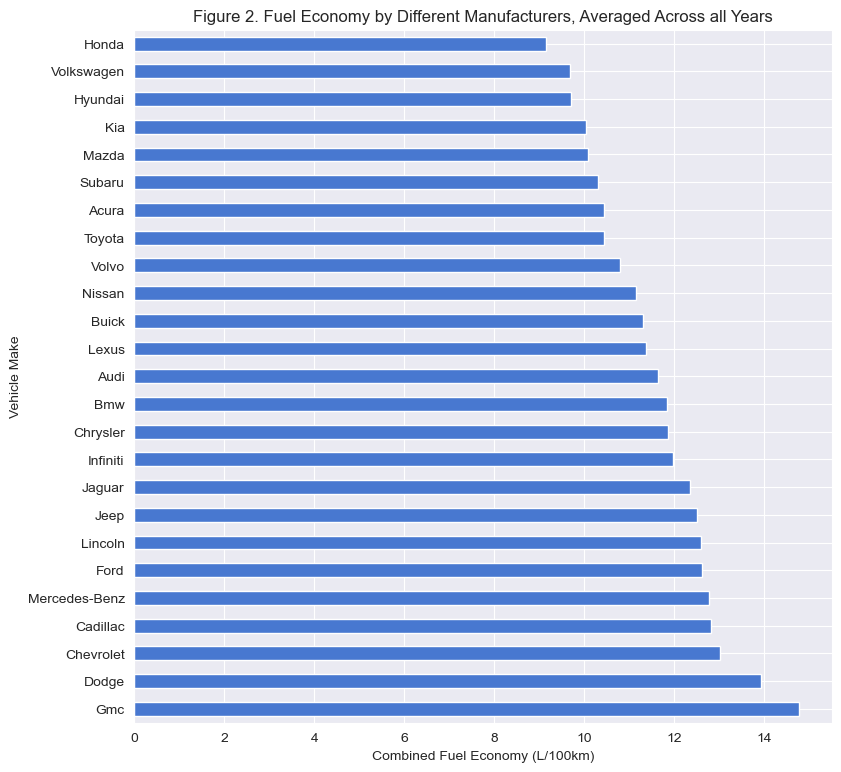

In [13]:
fuel_economy_by_year_and_make = full_dataset.pivot_table(index="model_year", 
                                                         columns="make", 
                                                         values="comb_lpkm", 
                                                         aggfunc="mean")

ax = fuel_economy_by_year_and_make.mean().sort_values(ascending=False).plot(kind="barh", figsize=(9, 9))
ax.set_ylabel("Vehicle Make")
ax.set_xlabel("Combined Fuel Economy (L/100km)")
ax.set_title("Figure 2. Fuel Economy by Different Manufacturers, Averaged Across all Years")

The figure above shows the average combined fuel economy for each manufacturer included in this investigation. On average, Honda vehicles are the most efficient while GMC are the least. These results will be unsurprising to most, since Honda primarily manufactures cars while GMC specializes in trucks and SUVs. 

It's evident then, that the vehicle type may play an important role in determining fuel economy. 

### 3.1.3 Vehicle Type

To assess the effect of vehicle type we created a boxplot separated by type. 

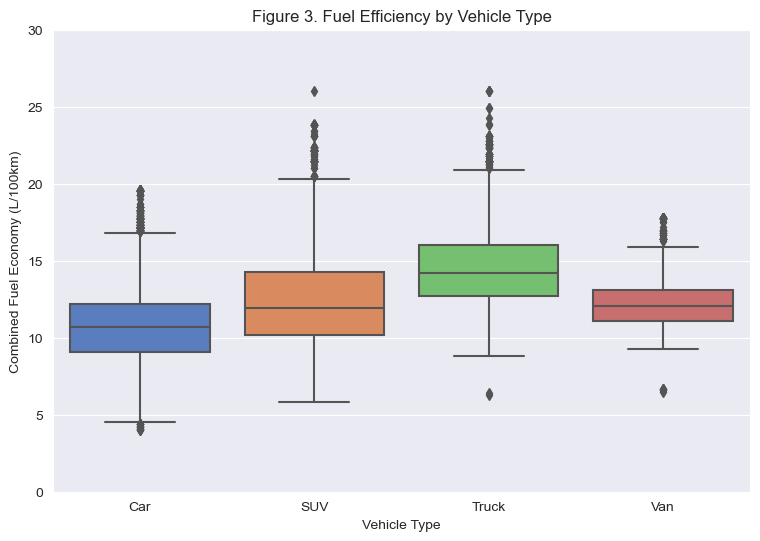

In [14]:
# fuel efficiency by vehicle type
ax = sns.boxplot(data=full_dataset, x="vehicle_class", y="comb_lpkm")
ax.set(xlabel="Vehicle Type", ylabel="Combined Fuel Economy (L/100km)", title="Figure 3. Fuel Efficiency by Vehicle Type")
ax.set_ylim(0, 30)
plt.gcf().set_size_inches(9, 6)

The figure above presents the average combined fuel economy for each vehicle class that was examined. It is evident that cars have the lowest average fuel economy, while SUVs and vans have similar means (although SUVs exhibit a greater degree of variation around it), and trucks have the highest average fuel economy.

### 3.1.4 Fuel Type

Similar to assessing vehicle types, we created boxplots to view the differences between the distributions of each fuel type. 

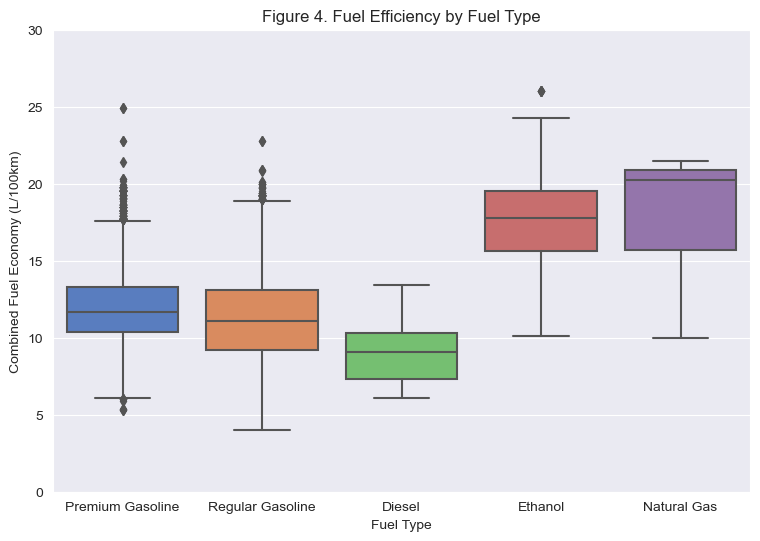

In [15]:
# fuel efficiency by fuel type
ax = sns.boxplot(data=full_dataset, x="fuel_type", y="comb_lpkm")
ax.set(xlabel="Fuel Type", ylabel="Combined Fuel Economy (L/100km)", title="Figure 4. Fuel Efficiency by Fuel Type")
ax.set_ylim(0, 30)
plt.gcf().set_size_inches(9, 6)

The figure above illustrates the combined fuel efficiency of different engine types. While the average is lowest for diesel vehicles, the lower range of both premium and regular gasoline vehicles appear more efficient than any observed diesel vehicle. That said, the upper range for both gasoline vehicles are far less efficient than any observed diesel vehicle. Ethanol and natural gas powered vehicles are evidently the least efficient in this dataset. However, natural gas has a relatively small sample size of only 18 observations, so it may be subject to sampling bias.

In [16]:
# how many of each number of fuel types?
full_dataset["fuel_type"].value_counts()

Regular Gasoline    10610
Premium Gasoline     7024
Ethanol               909
Diesel                377
Natural Gas            18
Name: fuel_type, dtype: int64

### 3.1.5 Engine Size

We use a scatter plot to compare the engine size and fuel economy of each vehicle. 

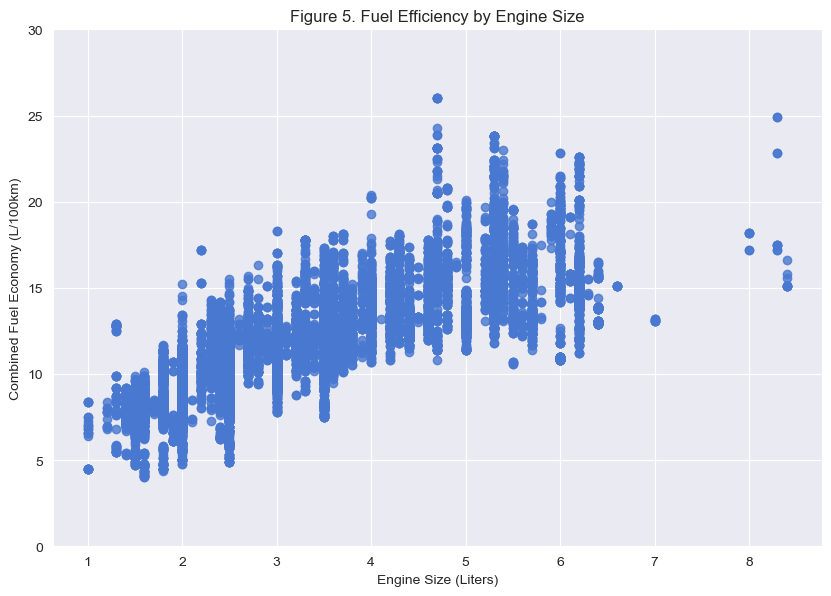

In [17]:
# fuel efficiency by engine size
ax = sns.lmplot(data=full_dataset, x="engine_size_L", y="comb_lpkm", fit_reg=False)
ax.set(xlabel="Engine Size (Liters)", ylabel="Combined Fuel Economy (L/100km)", 
       title="Figure 5. Fuel Efficiency by Engine Size")
ax.set(ylim=(0, 30))
plt.gcf().set_size_inches(9, 6)

The figure above shows a positive correlation between engine size and combined fuel economy. In simpler terms, it indicates that vehicles equipped with larger engines tend to be less fuel-efficient. 

### 3.1.6 Effect of Engine Cylinders

We use another scatterplot to compare each vehicles engine cylinders to it's fuel economy. 

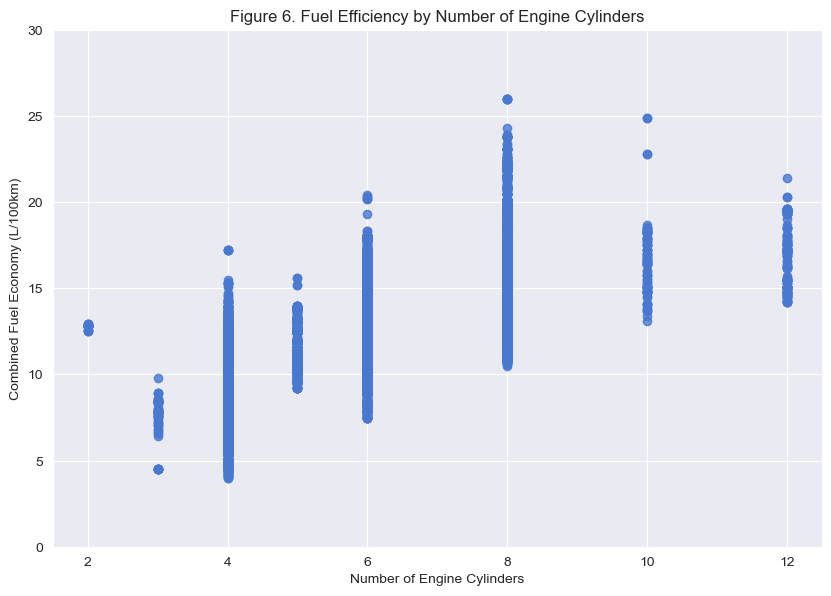

In [18]:
# fuel efficiency by engine cylinders
ax = sns.lmplot(data=full_dataset, x="cylinders", y="comb_lpkm", fit_reg=False)
ax.set(xlabel="Number of Engine Cylinders", ylabel="Combined Fuel Economy (L/100km)", 
       title="Figure 6. Fuel Efficiency by Number of Engine Cylinders")
ax.set(ylim=(0, 30))
ax.fig.set_size_inches(9, 6)

The figure above indicates a positive correlation between the number of engine cylinders and combined fuel economy for vehicles with more than 3 cylinders. Vehicles with 2 cylinders exhibit a higher than expected combined fuel economy; however, with a relatively small sample size of only 16 observations, it may be subject to sampling bias.

In [19]:
# how many of each number of engine cylinders?
full_dataset["cylinders"].value_counts()

4.0     6942
6.0     6779
8.0     4410
5.0      483
12.0     149
10.0     100
3.0       59
2.0       16
Name: cylinders, dtype: int64

The figure above indicates a positive correlation between the number of engine cylinders and combined fuel economy for vehicles with more than 3 cylinders. Vehicles with 2 cylinders exhibit a higher than expected combined fuel economy; however, with a relatively small sample size of only 16 observations, it may be subject to sampling bias.

### 3.1.7 Transmission Type

We use boxplots to plot the distribution of each transmission type against their fuel economy. 

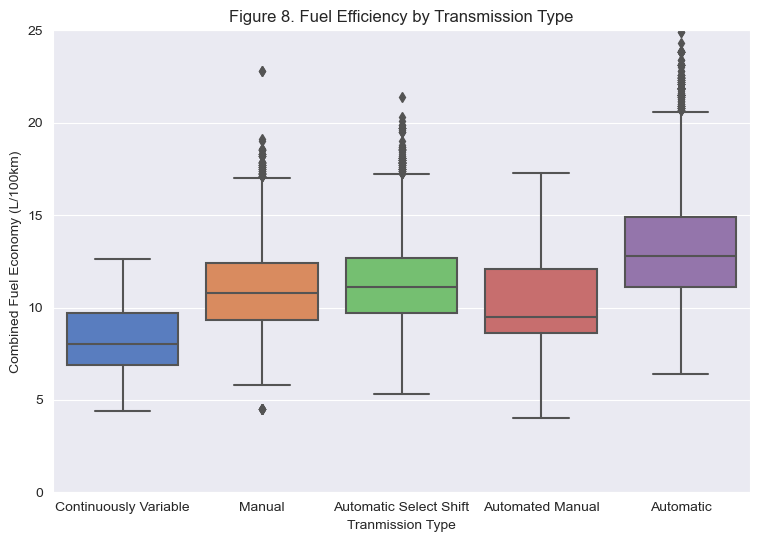

In [20]:
# fuel efficiency by transmission type
ax = sns.boxplot(data=full_dataset, x="transmission_type", y="comb_lpkm")
ax.set(xlabel="Tranmission Type", ylabel="Combined Fuel Economy (L/100km)", 
       title="Figure 8. Fuel Efficiency by Transmission Type")
ax.set(ylim=(0, 25))
plt.gcf().set_size_inches(9, 6)

This figure shows the combined fuel economy for each transmission type. Continuously variable transmissions looks to be the most fuel-efficient, while automatic transmission appear to be the least efficient. 

### 3.1.8 Number of Transmission Gears

The final variable is the number of transmission gears, which we've chosen to represent as a scatter plot.

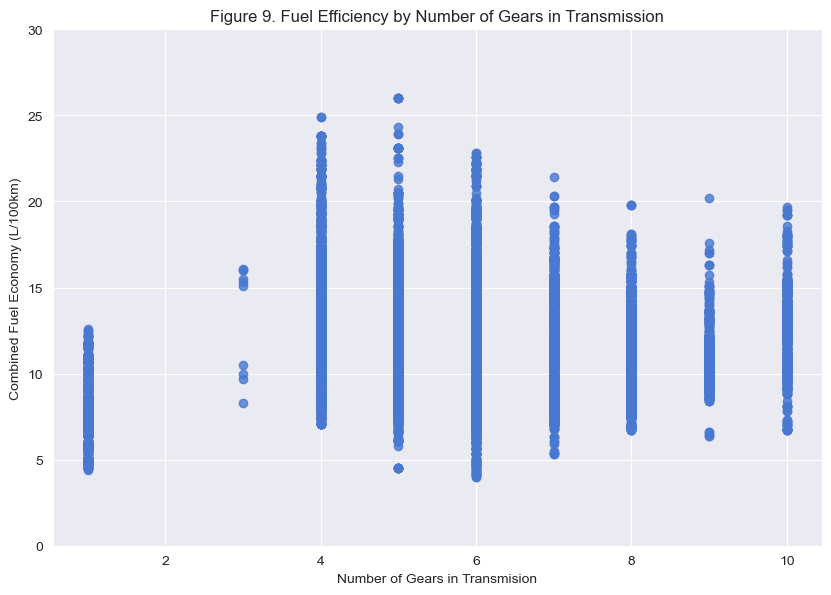

In [21]:
# fuel efficiency by transmission gears
ax = sns.lmplot(data=full_dataset, x="transmission_gears", y="comb_lpkm", fit_reg=False)
ax.set(xlabel="Number of Gears in Transmision", ylabel="Combined Fuel Economy (L/100km)", 
       title="Figure 9. Fuel Efficiency by Number of Gears in Transmission")
ax.set(ylim=(0, 30))
plt.gcf().set_size_inches(9, 6)

The figure above shows that the number of gears in transmission appears uncorrelated with the combined fuel economy. 

## 3.2 Interactions Between Year and Other Explanatory Variables

The previous section focused on exploring how each individual explanatory variable influences fuel efficiency. However, it was observed that the average fuel efficiency has improved from 2000 to 2023, which begs the question - is there an interaction between the year and some of the other factors?

This section will examine interactions between:
- Year and Make
- Year and Vehicle type
- Year and Fuel Type (e.g., have diesel engines improved in efficiency more than gas engines over time)
- Year and Transmission Type (e.g., have automatic transmissions improved in efficiency more than manual transmissions?)

### 3.2.1 Interaction between Year and Make

One rationale for exploring the relationship between year and make is that certain manufacturers may have improved their average fuel efficiency more than a different manufacturer over the 2000 to 2023 time period.

To assess this, we aggregate fuel efficiency data for all vehicles by year and make. The resulting figure is shown below.

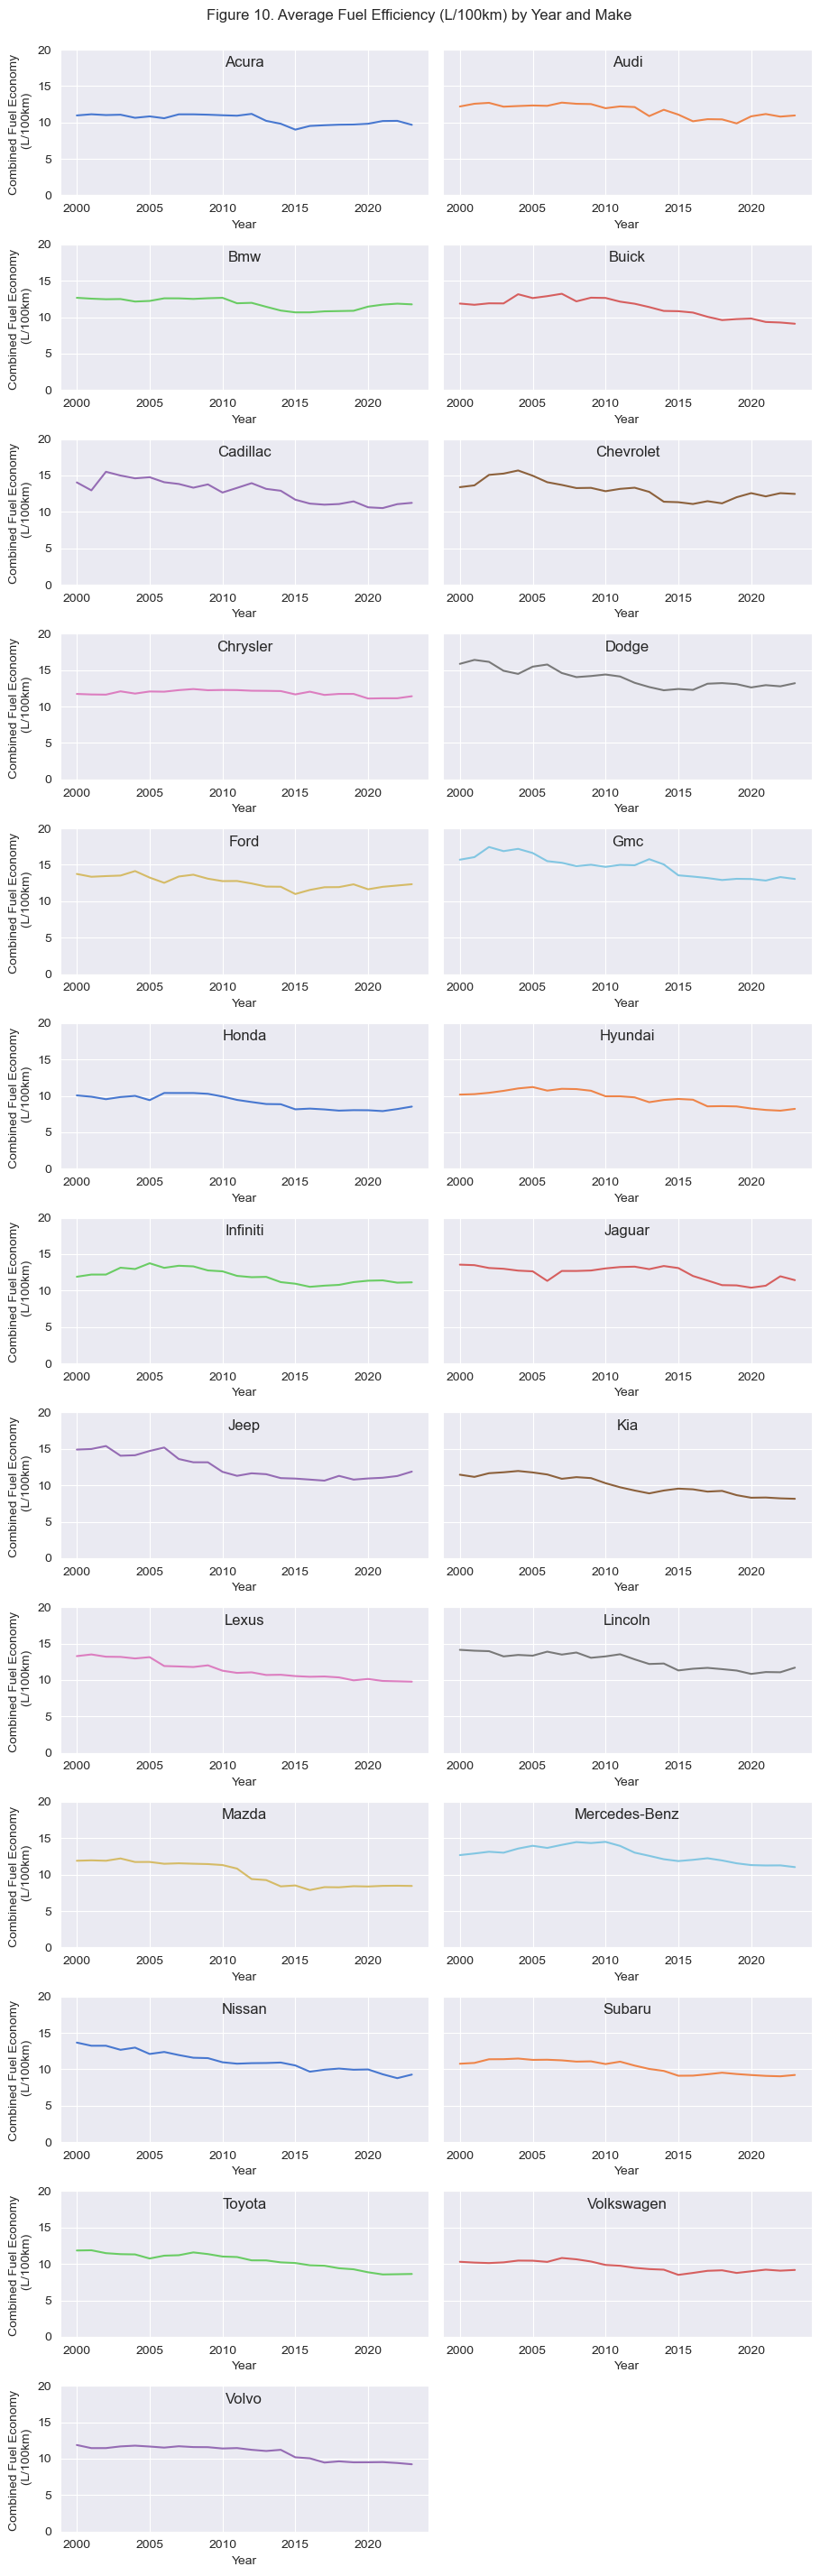

In [22]:
# exploring interaction between year and make
fuel_economy_by_year_and_make = full_dataset.pivot_table(index="model_year", 
                                                         columns="make", 
                                                         values="comb_lpkm", 
                                                         aggfunc="mean")

axs = fuel_economy_by_year_and_make.plot.line(
    figsize=(9, 30), subplots=True, legend=False, sharex=False,
    sharey=True, layout=(13, 2), xlabel="Year"
)

axs[0,0].get_figure().tight_layout(rect=[0, 0.03, 1, 0.97])
axs[0,0].get_figure().suptitle('Figure 10. Average Fuel Efficiency (L/100km) by Year and Make')
axs = axs.ravel()
titles = fuel_economy_by_year_and_make.columns
i = 0
for ax in axs[:-1]:
    title = titles[i]
    ax.set_title(title, y=1.0, pad=-14)
    ax.set_ylim(0, 20)
    ax.set_ylabel("Combined Fuel Economy \n (L/100km)")
    i += 1

From the figure above, there are a few interesting observations.

First, fuel efficiency did not improve in every single year for all manufacturers. For example, Chevrolet, Hyundai, and Infiniti saw their average fuel efficiency get worse from 2000 to 2005.

Second, every manufacturer improved their average fuel efficiency from 2000 to 2023. However, it is apparent that there is variation in how much each manufacturer has improved. For example, it appears that Acura and Subaru have made minimal improvements in average fuel efficiency from 2000 to 2023 (although they both started with relatively low averages). In contrast, Mazda and Toyota have made much larger improvements in average fuel efficiency from 2000 to 2023.

To refine this analysis, we will group companies based on whether their fuel efficiency has improved by <15%, between 15% to 20%, or >20%.

Text(0.5, 0, 'Year')

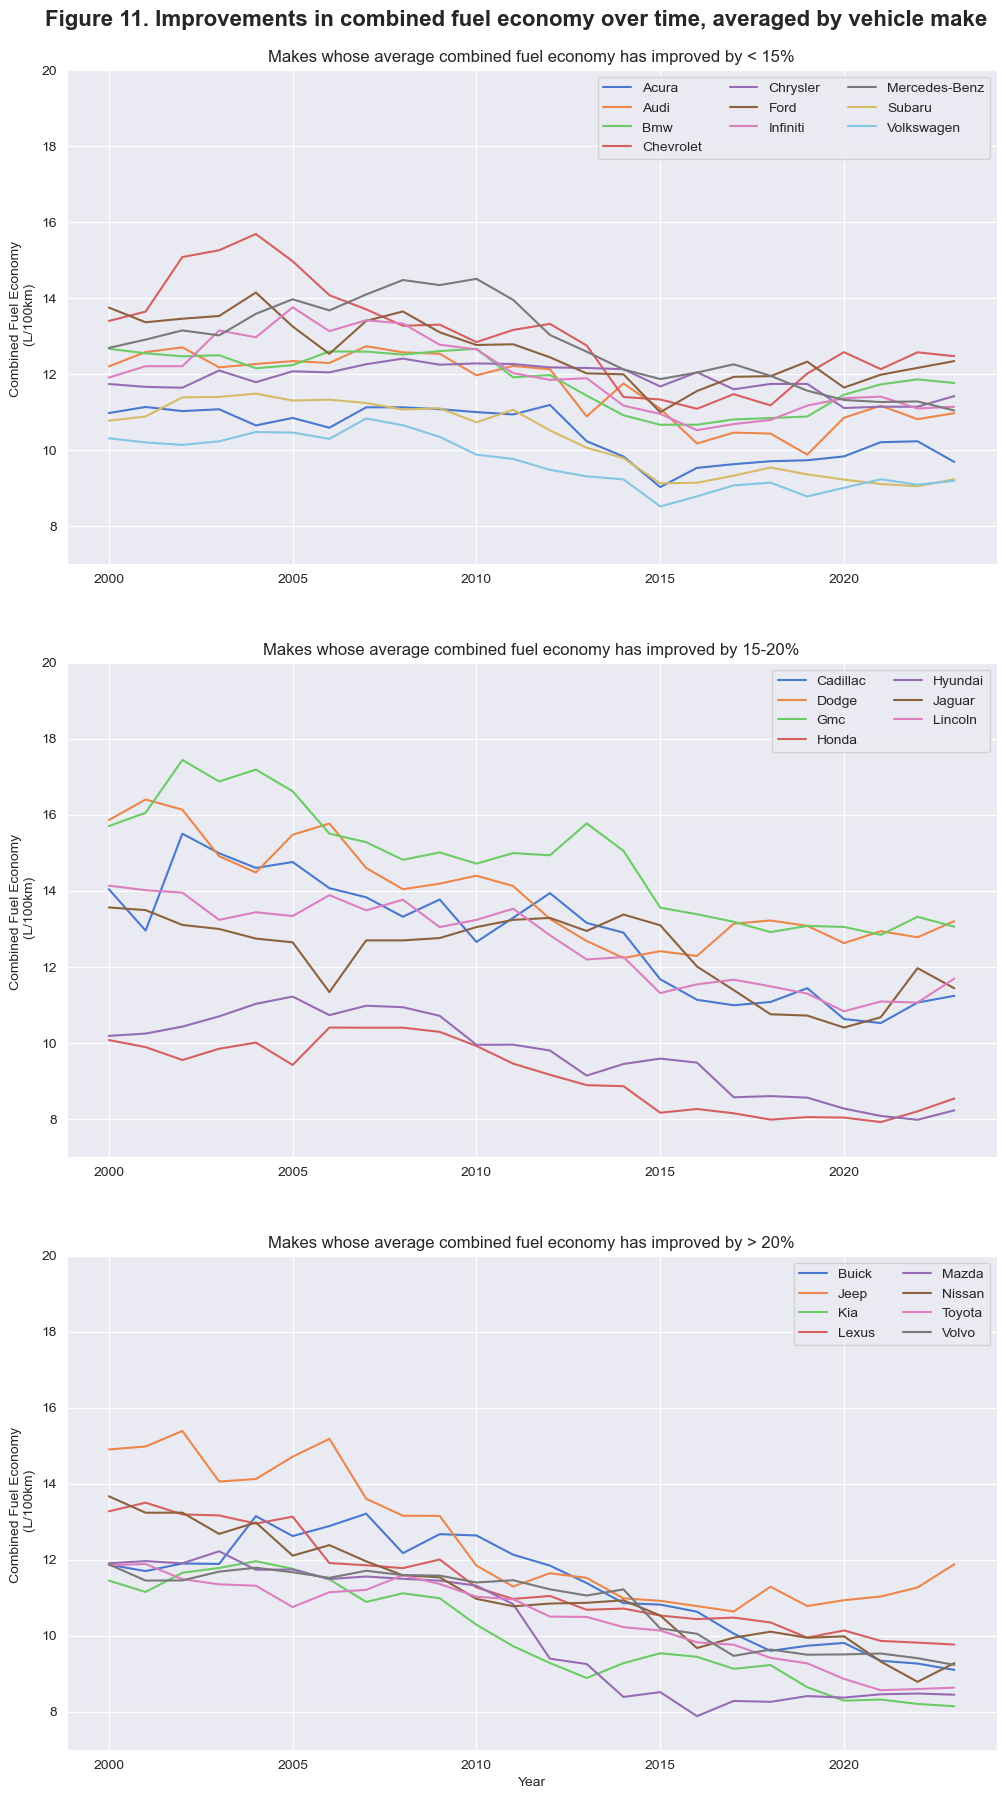

In [23]:
fuel_economy_by_year_and_make = full_dataset.pivot_table(index="model_year", 
                                                         columns="make", 
                                                         values="comb_lpkm", 
                                                         aggfunc="mean")

# separate dataset into makes which have decreased combined fuel economy by >= 15%, 20% and those who haven't
ratio = (fuel_economy_by_year_and_make.loc[2023] / fuel_economy_by_year_and_make.loc[2000])
flats = fuel_economy_by_year_and_make.loc[:, ratio >= 0.85]
mids = fuel_economy_by_year_and_make.loc[:, (ratio >= 0.8) & (ratio < 0.85)]
declining = fuel_economy_by_year_and_make.loc[:, ratio < 0.8]

fig, ax = plt.subplots(3, figsize=(12, 20))
fig.suptitle("Figure 11. Improvements in combined fuel economy over time, averaged by vehicle make", 
            fontsize=16, fontweight='bold')
fig.subplots_adjust(top=0.95)
ax[0].plot(flats)
ax[0].set_ylim(7,20)
ax[0].legend(labels=flats.columns, loc='upper right', ncol=3)
ax[0].set_title('Makes whose average combined fuel economy has improved by < 15%')
ax[0].set_ylabel("Combined Fuel Economy \n (L/100km)")
ax[1].plot(mids)
ax[1].set_ylim(7,20)
ax[1].legend(labels=mids.columns, loc='upper right', ncol=2)
ax[1].set_title('Makes whose average combined fuel economy has improved by 15-20%')
ax[1].set_ylabel("Combined Fuel Economy \n (L/100km)")
ax[2].plot(declining)
ax[2].set_ylim(7,20)
ax[2].legend(labels=declining.columns, loc='upper right', ncol=2)
ax[2].set_title('Makes whose average combined fuel economy has improved by > 20%')
ax[2].set_ylabel("Combined Fuel Economy \n (L/100km)")
ax[2].set_xlabel("Year")

This figure displays the changes in average combined fuel economy over time for each manufacturer from 2000-2023. Buick, Jeep, Kia, Lexus, Maxda, Nissan, Toyota and Volvo were found to have improved their average vehicle combined fuel economy by tho most, each boasting over 20% improvement since 2000. No individual manufacturer, even amongst the least improved group, had an increase in average fuel economy over this period. 

### 3.2.2 Interaction Between Year and Vehicle Class

One rationale for exploring the relationship between year and vehicle is that certain categories of vehicles may have improved more than others over time. For example, SUVs are commonly thought of as "gas guzzlers". But have they improved more than cars from 2000 to 2023?

To assess this, we aggregate fuel efficiency data for all vehicles by year and vehicle type. The resulting figure is shown below.

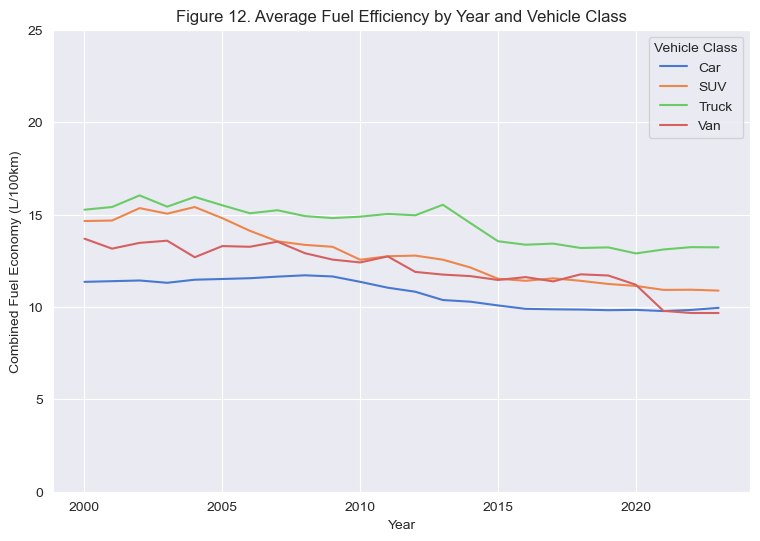

In [24]:
fuel_economy_by_year_and_vehicle_type = full_dataset.pivot_table(index="model_year", 
                                                                 columns="vehicle_class", 
                                                                 values="comb_lpkm", 
                                                                 aggfunc="mean")

ax = fuel_economy_by_year_and_vehicle_type.plot.line()
ax.set_xlabel("Year")
ax.set_ylabel("Combined Fuel Economy (L/100km)")
ax.set_ylim(0, 25)
ax.set_title("Figure 12. Average Fuel Efficiency by Year and Vehicle Class")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title="Vehicle Class", loc='upper right')
plt.gcf().set_size_inches(9, 6)

In [25]:
original_average = fuel_economy_by_year_and_vehicle_type.T[2000]
new_average = fuel_economy_by_year_and_vehicle_type.T[2023]
percent_diff = abs(new_average - original_average)/original_average*100
percent_diff

vehicle_class
Car      12.389191
SUV      25.694914
Truck    13.357296
Van      29.362664
dtype: float64

From the figure above, we see that all vehicle types have experienced an improvement in fuel efficiency from 2000 to 2023. It is observed that:
- Cars experienced the smallest improvement, at 12.4%. However, cars consistently had the best average fuel efficiency except for in 2021 to 2023.
- Trucks experienced a 13.4% improvement. They also had the worst average fuel efficiency across all the years examined.
- SUVs experienced a 25.7% improvement. They initially started with an average fuel efficiency close to trucks in 2000, but ended up with an average fuel efficiency closer to cars and vans in 2023.
- Vans experienced the largest improvement, at 29.4%. In 2021, they overtook cars as having the most efficient average fuel economy.

If a consumer is in the market for a fuel-efficient vehicle, the impact of the model year on their decision differs depending on the type of vehicle they want. For instance, if they are interested in a fuel-efficient car or truck, the model year may not be as crucial as it would be if they were searching for a fuel-efficient SUV or van. In those cases, it would be advisable to consider newer vehicles if possible.

### 3.2.3 Interaction between Year and Fuel Type

For the average consumer, the primary fuel types to consider are premium or regular gasoline since diesel, ethanol, and natural gas vehicles are usually specialized. Some vehicle engines are manufactured to perform optimally when given higher octane fuel (premium gasoline), whereas for others regular gasoline is suffucicient. 

We'll use the visualization below to compare the improvements in efficiency for each fuel type over time. 

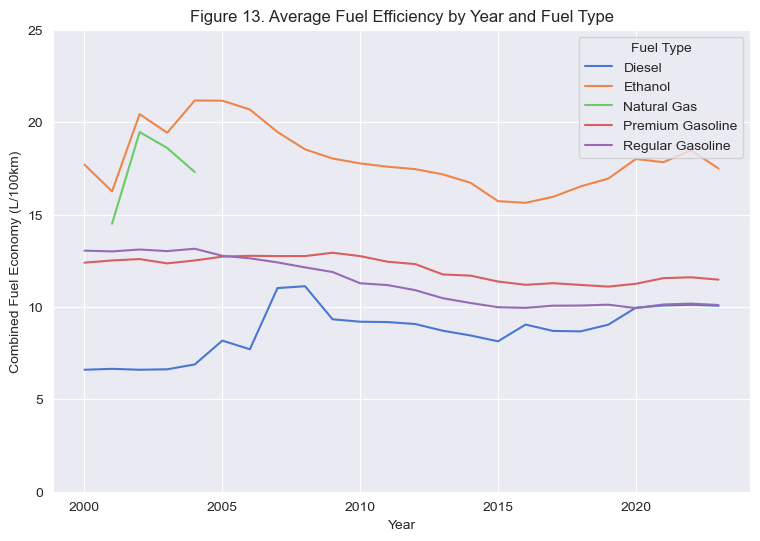

In [26]:
fuel_economy_by_year_and_fuel_type = full_dataset.pivot_table(index="model_year", 
                                                              columns="fuel_type", 
                                                              values="comb_lpkm", 
                                                              aggfunc="mean")
ax = fuel_economy_by_year_and_fuel_type.plot.line()
ax.set_xlabel("Year")
ax.set_ylabel("Combined Fuel Economy (L/100km)")
ax.set_ylim(0, 25)
ax.set_title("Figure 13. Average Fuel Efficiency by Year and Fuel Type")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title="Fuel Type", loc='upper right')
plt.gcf().set_size_inches(9, 6)

Between regular and premium gasoline vehicles, regular gasoline vehicles have improved in efficiency the most since 2000. While premium gasoline vehicles started the century as the slightly more efficient fuel type, they by 2005 they were overtaken by regular gasoline vehicles. Regualar gasoline vehicles decreased their average combined fuel efficiency from around 13.0 in 2000 down to 10.1 in 2023, while premium gasoline vehicles only saw a decrease from 12.4 to 11.5 over that same time period. 

### 3.2.4 Interaction between Year and Transmission Type

Transmission type (beyond the distinction between manual and automatic), may be an overlooked factor when purchasing a vehicle. While we saw in Figure 8 that continuously variable transmission vehicles tend to be more efficient overall, it begs the question how vehicle efficiency for each transmission type has changed over time. We explore these changes through a visualization and comparing the percent improvements. 

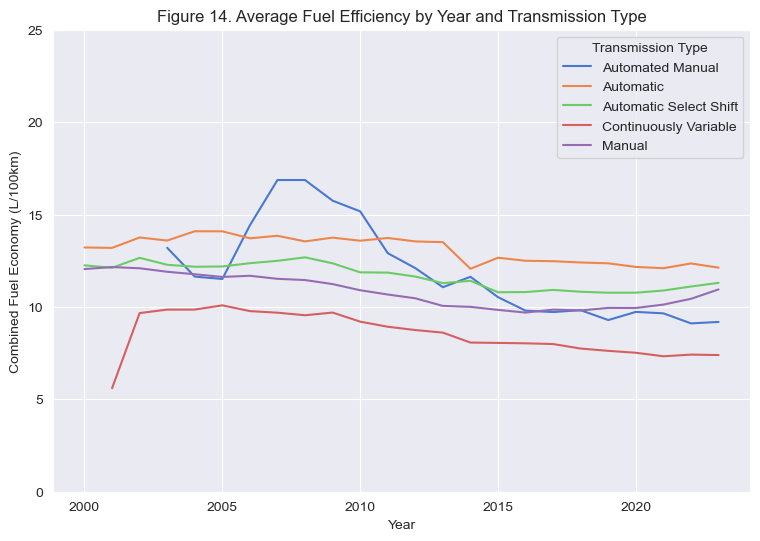

In [27]:
fuel_economy_by_year_and_transmission_type = full_dataset.pivot_table(index="model_year", 
                                                                      columns="transmission_type", 
                                                                      values="comb_lpkm", 
                                                                      aggfunc="mean")

ax = fuel_economy_by_year_and_transmission_type.plot.line()
ax.set_xlabel("Year")
ax.set_ylabel("Combined Fuel Economy (L/100km)")
ax.set_ylim(0, 25)
ax.set_title("Figure 14. Average Fuel Efficiency by Year and Transmission Type")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title="Transmission Type", loc='upper right')
plt.gcf().set_size_inches(9, 6)

In [28]:
original_average = fuel_economy_by_year_and_transmission_type.T[2002]
new_average = fuel_economy_by_year_and_transmission_type.T[2023]
percent_diff = abs(new_average - original_average)/original_average*100
percent_diff

transmission_type
Automated Manual                NaN
Automatic                 11.865466
Automatic Select Shift    10.700374
Continuously Variable     23.484787
Manual                     9.461606
dtype: float64

For this comparison, 2002 was chosen as the baseline, since CVT is a new technology as was not prominent before then (hense the oddity in the CVT measurement from 2001 in the visualization above). 

CVT has consistently been the most efficient fuel type for every year since it's inception, and also boasts the most improved fuel economy over the period from 2002-2023 (23.5%). It's clear then, that newer CVT vehicles are the optimal choice if available. For other transmission types, we see a much smaller improvement in average fuel economy over time. 

## 3.3 Most Efficient Vehicles and Makes

If a consumer is simply looking for the most efficient vehicle on the market, we can caluclate that here:

In [29]:
# finding the most efficient vehicle
min_ID = full_dataset["comb_lpkm"].idxmin()
most_efficient_comb_lpkm = full_dataset["comb_lpkm"][min_ID]
most_efficient_year = full_dataset["model_year"][min_ID]
most_efficient_make = full_dataset["make"][min_ID]
most_efficient_model = full_dataset["model"][min_ID]
print(f"The {most_efficient_make} {most_efficient_model} from {most_efficient_year} " + 
      f"was the most efficient vehicle at {most_efficient_comb_lpkm} L/100km")

# finding the least efficient vehicle
max_ID = full_dataset["comb_lpkm"].idxmax()
least_efficient_comb_lpkm = full_dataset["comb_lpkm"][max_ID]
least_efficient_year = full_dataset["model_year"][max_ID]
least_efficient_make = full_dataset["make"][max_ID]
least_efficient_model = full_dataset["model"][max_ID]
print(f"The {least_efficient_make} {least_efficient_model} from {least_efficient_year} " + 
      f"was the least efficient vehicle at {least_efficient_comb_lpkm} L/100km")

The Hyundai IONIQ Blue from 2022 was the most efficient vehicle at 4.0 L/100km
The Dodge RAM 1500 4X4 FFV from 2005 was the least efficient vehicle at 26.0 L/100km


The 2022 Hyundai IONIQ Blue is the most efficient vehicle in our dataset, boasting a combined fuel economy of 4 L/100km, while the least efficient vehicle was the 2005 Dodge RAM 1500 4X4 FFV with a combined fuel economy of 26 L/100km. However price and functionality are also generally considerations when purchasing a vehicle. As price generally decreases over time, by separating each make by vehicle class and obtaining an average fuel economy for each year we can point consumers in the right direction based on their desired vehicle type and budget. 

In [30]:
# exploring which companies made the most efficient vehicles in each year, based on vehicle class
fuel_economy_by_year_make_and_vehicle_type = full_dataset.pivot_table(index=["model_year", "make"], 
                                                                      columns="vehicle_class", 
                                                                      values="comb_lpkm", 
                                                                      aggfunc="mean")

fuel_economy_by_year_make_and_vehicle_type.reset_index(["model_year"], inplace=True)
fuel_economy_by_year_make_and_vehicle_type

by_year = fuel_economy_by_year_make_and_vehicle_type.groupby("model_year")
by_year.idxmin()

vehicle_class      Car      SUV    Truck        Van
model_year                                         
2000             Honda   Subaru   Nissan  Chevrolet
2001             Honda   Subaru   Toyota  Chevrolet
2002             Honda   Subaru    Mazda  Chevrolet
2003             Honda   Subaru   Toyota  Chevrolet
2004             Honda    Mazda    Mazda      Dodge
2005             Honda   Subaru    Mazda      Honda
2006             Honda   Subaru    Mazda      Honda
2007            Toyota   Subaru    Mazda     Toyota
2008            Toyota   Subaru    Mazda      Mazda
2009            Toyota   Subaru    Mazda      Mazda
2010             Honda  Hyundai    Mazda      Mazda
2011             Honda  Hyundai   Toyota       Ford
2012            Toyota      Kia   Toyota      Mazda
2013            Toyota    Mazda   Toyota      Mazda
2014            Toyota    Mazda   Toyota      Mazda
2015            Toyota   Subaru    Dodge  Chevrolet
2016            Toyota    Mazda   Nissan  Chevrolet
2017            Toyota   Subaru    Honda  Chevrolet
2018            Toyota   Subaru    Honda      Honda
2019            Toyota   Subaru    Honda      Honda
2020               Kia   Subaru    Honda      Honda
2021           Hyundai   Subaru     Jeep     Toyota
2022               Kia  Hyundai  Hyundai     Toyota
2023            Toyota      Kia  Hyundai     Toyota

As can be seen in the table above, the most efficient make per year for each vehicle type changes year by year. Most recently, Toyota manufactures on average the most efficient cars and vans, while kia and hyundai manufacture the most efficient SUVs and Trucks respectively. 

## 4. Fitting Models

Predicting a vehicle's fuel economy could have wide ranging applications from insentives to invoke custom builds and modifications to existing models, to decisions on purchasing a vehicle this year versus waiting for next year's model. 

In section 4a we create a linear regression and lasso model assuming no interactions between predictors. 

In section 4b we create a new model considering the interaction between each predictor and the model year.

In section 4c we test our model against new 2024 vehicles that have yet to be included in our data. 

### 4a. No Interactions

We begin by splitting our data into training (75%) and testing (25%) sets, and fitting a simple regresison model to predict combined fuel economy considering each predictor. We obtain a mean squared error on each of the training and testing data. 

In [31]:
# create X and y training and testing datasets
y, X = patsy.dmatrices("comb_lpkm ~ model_year + C(make) + C(vehicle_class) + " +
                       "C(fuel_type) + engine_size_L + cylinders + C(transmission_type) + " +
                        "transmission_gears", full_dataset, return_type='matrix')
train = full_dataset.sample(frac = 0.75,random_state = 42) 
test = full_dataset.drop(train.index)
y_train = y[train.index]
X_train = X[train.index]
y_test = y[test.index]
X_test = X[test.index]

In [32]:
# fit a linear regression model
fuel_efficiency_lr_model = linear_model.LinearRegression()
fuel_efficiency_lr_model.fit(X_train, y_train)

mse_train = metrics.mean_squared_error(y_train, fuel_efficiency_lr_model.predict(X_train))
mse_test = metrics.mean_squared_error(y_test, fuel_efficiency_lr_model.predict(X_test))

print(f"The MSE on the training data is: {mse_train} and the MSE on the testing data is {mse_test}")

The MSE on the training data is: 1.1562306525157737 and the MSE on the testing data is 1.1464329677299818


Next we'll refit the trainig and testing data using a lasso model in order to see if there's any benefit to excluding some preditors. 

In [33]:
# fit a lasso regression model
fuel_efficiency_lasso_model = linear_model.Lasso()
fuel_efficiency_lasso_model.fit(X_train, y_train)

mse_train = metrics.mean_squared_error(y_train, fuel_efficiency_lasso_model.predict(X_train))
mse_test = metrics.mean_squared_error(y_test, fuel_efficiency_lasso_model.predict(X_test))

print(f"The MSE on the training data is: {mse_train} and the MSE on the testing data is {mse_test}")

The MSE on the training data is: 3.5598818771509877 and the MSE on the testing data is 3.5727824933361005


In [34]:
param_names = X.design_info.column_names
lasso_coefs = pd.Series(dict(zip(param_names, fuel_efficiency_lasso_model.coef_)))
lr_coefs = pd.Series(dict(zip(param_names, fuel_efficiency_lr_model.coef_[0])))
coefs = pd.DataFrame(dict(lasso=lasso_coefs, linreg=lr_coefs))
coefs

lasso        linreg
Intercept                                       0.000000  3.707734e-16
C(make)[T.Audi]                                -0.000000  8.779234e-01
C(make)[T.Bmw]                                 -0.000000  3.937258e-01
C(make)[T.Buick]                                0.000000  4.292638e-01
C(make)[T.Cadillac]                             0.000000  8.221932e-01
C(make)[T.Chevrolet]                            0.000000  5.889257e-02
C(make)[T.Chrysler]                            -0.000000  4.483304e-01
C(make)[T.Dodge]                                0.000000  5.083677e-01
C(make)[T.Ford]                                 0.000000  6.066483e-01
C(make)[T.Gmc]                                  0.000000  2.456136e-01
C(make)[T.Honda]                               -0.000000  8.860858e-02
C(make)[T.Hyundai]                             -0.000000  1.391246e-01
C(make)[T.Infiniti]                            -0.000000  2.836509e-01
C(make)[T.Jaguar]                              -0.000000  3.594447e-01
C(make)[T.Jeep]                                 0.000000  6.130736e-01
C(make)[T.Kia]                                 -0.000000  3.329366e-01
C(make)[T.Lexus]                               -0.000000 -2.071268e-01
C(make)[T.Lincoln]                              0.000000  1.094459e+00
C(make)[T.Mazda]                               -0.000000  2.512556e-01
C(make)[T.Mercedes-Benz]                       -0.000000  5.955948e-01
C(make)[T.Nissan]                              -0.000000  7.461752e-01
C(make)[T.Subaru]                              -0.000000  1.037248e+00
C(make)[T.Toyota]                              -0.000000 -4.973015e-02
C(make)[T.Volkswagen]                          -0.000000  4.486834e-01
C(make)[T.Volvo]                               -0.000000  7.712173e-01
C(vehicle_class)[T.SUV]                         0.000000  1.567616e+00
C(vehicle_class)[T.Truck]                       0.000000  2.132012e+00
C(vehicle_class)[T.Van]                         0.000000  1.069314e+00
C(fuel_type)[T.Ethanol]                         0.000000  5.890224e+00
C(fuel_type)[T.Natural Gas]                     0.000000  4.829778e+00
C(fuel_type)[T.Premium Gasoline]               -0.000000  2.240045e+00
C(fuel_type)[T.Regular Gasoline]               -0.000000  1.599675e+00
C(transmission_type)[T.Automatic]               0.000000  1.330468e-02
C(transmission_type)[T.Automatic Select Shift] -0.000000 -3.984888e-02
C(transmission_type)[T.Continuously Variable]  -0.000000 -1.756535e+00
C(transmission_type)[T.Manual]                 -0.000000  5.127031e-02
model_year                                     -0.084205 -9.153017e-02
engine_size_L                                   0.333856  7.792375e-01
cylinders                                       0.697889  4.766608e-01
transmission_gears                              0.000000 -5.471057e-02

Because we see a higher MSE for the testing data in the lasso model, that suggests that the original regression is a more effective predictor. 

We can see in the lasso model that cylinders, engine size, and model year were the three most influential predictors. However, we may benefit from tuning the lasso model through a 5-fold validation to optimize alpha. 

Text(-0.8334944602183618, 8.731803803987514, '5 fold cross-validation')

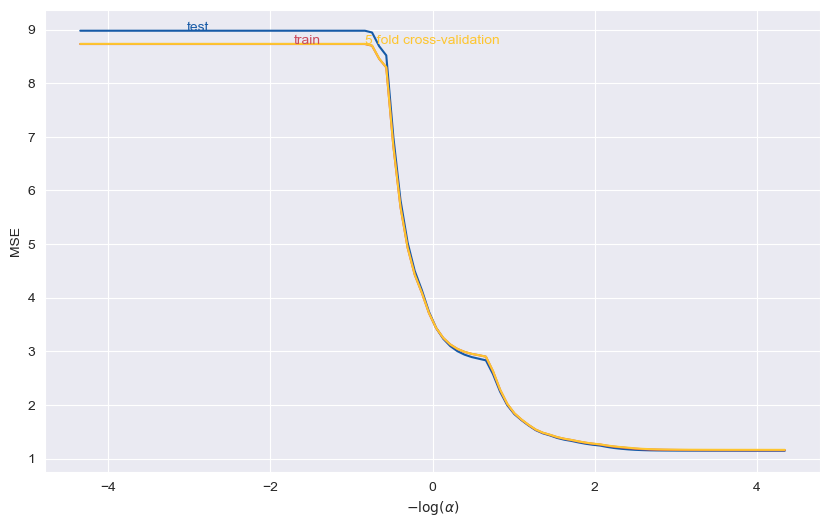

In [35]:
# number of cross-validation folds
k = 5

# create a function for calculating mses
def fit_and_report_mses(mod, X_train, X_test, y_train, y_test):
    mod.fit(X_train, y_train)
    return dict(
        mse_train=metrics.mean_squared_error(y_train, mod.predict(X_train)),
        mse_test=metrics.mean_squared_error(y_test, mod.predict(X_test))
    )

# create the alphas and mse values for different alphas
alphas = np.exp(np.linspace(10, -10, 100))
mse = pd.DataFrame([fit_and_report_mses(linear_model.Lasso(alpha=alpha, max_iter=50000),
                           X_train, X_test, y_train, y_test)
                    for alpha in alphas])
mse["log_alpha"] = -np.log10(alphas)
mse["cv"] = [-np.mean(cross_val_score(linear_model.Lasso(alpha=alpha, max_iter=50000),
                                  X_train, y_train, cv=k, scoring='neg_mean_squared_error'))
          for alpha in alphas]

# create the plot
colors = ['#165aa7', '#cb495c', '#fec630']
fig, ax = plt.subplots(figsize=(10,6))
mse.plot(x="log_alpha", y="mse_test", c=colors[0], ax=ax)
mse.plot(x="log_alpha", y="mse_train", c=colors[1], ax=ax)
mse.plot(x="log_alpha", y="cv", c=colors[2], ax=ax)
ax.set_xlabel(r"$-\log(\alpha)$")
ax.set_ylabel("MSE")
ax.get_legend().remove()
ax.annotate("test",(mse.log_alpha[15], mse.mse_test[15]),color=colors[0])
ax.annotate("train",(mse.log_alpha[30], mse.mse_train[30]),color=colors[1])
ax.annotate(f"{k} fold cross-validation", (mse.log_alpha[40], mse.cv[40]), color=colors[2])

In [36]:
#retrieve optimal alpha
lasso = linear_model.LassoCV(cv=5).fit(X_train,y_train)
neg_log_alpha = -np.log10(lasso.alpha_)
alpha = 10**(-1 * neg_log_alpha)
print(f"The optimal alpha is {alpha}")

The optimal alpha is 0.005686607057392209


# I added cell above, ask Alex how he got 0.01 for alpha (just rounded?), not sure why I'm off but wanted to add this tuning for the interaction section below as well and that result not making sense to me. 

In [37]:
# fit an updated lasso regression model with an alpha to optimize MSE
fuel_efficiency_lasso_model = linear_model.Lasso(alpha=0.01)
fuel_efficiency_lasso_model.fit(X_train, y_train)

mse_train = metrics.mean_squared_error(y_train, fuel_efficiency_lasso_model.predict(X_train))
mse_test = metrics.mean_squared_error(y_test, fuel_efficiency_lasso_model.predict(X_test))

print(f"The MSE on the training data is: {mse_train} and the MSE on the testing data is {mse_test}")

The MSE on the training data is: 1.272397201130612 and the MSE on the testing data is 1.2529223857901797


In [38]:
param_names = X.design_info.column_names
lasso_coefs = pd.Series(dict(zip(param_names, fuel_efficiency_lasso_model.coef_)))
lr_coefs = pd.Series(dict(zip(param_names, fuel_efficiency_lr_model.coef_[0])))
coefs = pd.DataFrame(dict(lasso=lasso_coefs, linreg=lr_coefs))
coefs

lasso        linreg
Intercept                                       0.000000  3.707734e-16
C(make)[T.Audi]                                 0.180688  8.779234e-01
C(make)[T.Bmw]                                 -0.000000  3.937258e-01
C(make)[T.Buick]                                0.000000  4.292638e-01
C(make)[T.Cadillac]                             0.000000  8.221932e-01
C(make)[T.Chevrolet]                           -0.220961  5.889257e-02
C(make)[T.Chrysler]                             0.000000  4.483304e-01
C(make)[T.Dodge]                                0.000000  5.083677e-01
C(make)[T.Ford]                                 0.146504  6.066483e-01
C(make)[T.Gmc]                                 -0.000000  2.456136e-01
C(make)[T.Honda]                               -0.009957  8.860858e-02
C(make)[T.Hyundai]                             -0.000000  1.391246e-01
C(make)[T.Infiniti]                            -0.000000  2.836509e-01
C(make)[T.Jaguar]                              -0.000000  3.594447e-01
C(make)[T.Jeep]                                 0.000000  6.130736e-01
C(make)[T.Kia]                                 -0.000000  3.329366e-01
C(make)[T.Lexus]                               -0.321104 -2.071268e-01
C(make)[T.Lincoln]                              0.000000  1.094459e+00
C(make)[T.Mazda]                               -0.000000  2.512556e-01
C(make)[T.Mercedes-Benz]                        0.000000  5.955948e-01
C(make)[T.Nissan]                               0.056284  7.461752e-01
C(make)[T.Subaru]                               0.233498  1.037248e+00
C(make)[T.Toyota]                              -0.255333 -4.973015e-02
C(make)[T.Volkswagen]                          -0.000000  4.486834e-01
C(make)[T.Volvo]                                0.000000  7.712173e-01
C(vehicle_class)[T.SUV]                         1.411547  1.567616e+00
C(vehicle_class)[T.Truck]                       1.853096  2.132012e+00
C(vehicle_class)[T.Van]                         0.525397  1.069314e+00
C(fuel_type)[T.Ethanol]                         4.116316  5.890224e+00
C(fuel_type)[T.Natural Gas]                     0.000000  4.829778e+00
C(fuel_type)[T.Premium Gasoline]                0.583788  2.240045e+00
C(fuel_type)[T.Regular Gasoline]                0.000000  1.599675e+00
C(transmission_type)[T.Automatic]               0.000000  1.330468e-02
C(transmission_type)[T.Automatic Select Shift] -0.000000 -3.984888e-02
C(transmission_type)[T.Continuously Variable]  -1.413491 -1.756535e+00
C(transmission_type)[T.Manual]                  0.000000  5.127031e-02
model_year                                     -0.101880 -9.153017e-02
engine_size_L                                   0.849315  7.792375e-01
cylinders                                       0.457795  4.766608e-01
transmission_gears                             -0.021436 -5.471057e-02

In this optimized lasso, we see the inclusion of more predictors has reduced the MSE considerably. However, it is still higher than the MSE of the original linear regression model for both the training and testing sets. 

In that case, we can try modelling a regression tree and neural network, and assess if either is able to improve the MSE of the testing set. 

For the regression tree, we'll test various depths in order to optimize the MSE on the testing set.

In [39]:
# fitting a regression tree
depths = [5, 10, 15, 20, 25, 30]
for depth in depths:
    fuel_efficiency_fitted_tree = tree.DecisionTreeRegressor(max_depth=depth, random_state=123).fit(X_train,y_train)
    mse_train = metrics.mean_squared_error(y_train, fuel_efficiency_fitted_tree.predict(X_train))
    mse_test = metrics.mean_squared_error(y_test, fuel_efficiency_fitted_tree.predict(X_test))
    print(f"With depth {depth}, the MSE on the training data is: {mse_train} and the MSE on the testing data is {mse_test}")

With depth 5, the MSE on the training data is: 1.582550239614631 and the MSE on the testing data is 1.6859932362832024
With depth 10, the MSE on the training data is: 0.6429651732258016 and the MSE on the testing data is 0.7796143581367635
With depth 15, the MSE on the training data is: 0.28206535891976536 and the MSE on the testing data is 0.5414509686523233
With depth 20, the MSE on the training data is: 0.19843555360148868 and the MSE on the testing data is 0.5291956921451613
With depth 25, the MSE on the training data is: 0.18122228534018578 and the MSE on the testing data is 0.5325569144647978
With depth 30, the MSE on the training data is: 0.1785449419803935 and the MSE on the testing data is 0.5370911686596977


The optimal depth is 20, where with an MSE of 0.529 on the testing set, we see a stark improvemnt over any of the previous models. 

In [40]:
# fitting a neural network
fuel_efficiency_nn_scaled_model = pipeline.make_pipeline(
    preprocessing.StandardScaler(),
    neural_network.MLPRegressor((100, 100), max_iter=500, random_state=123)
)
 
fuel_efficiency_nn_scaled_model.fit(X_train, y_train.flatten())
mse_nn_train = metrics.mean_squared_error(y_train, fuel_efficiency_nn_scaled_model.predict(X_train))
mse_nn_test = metrics.mean_squared_error(y_test, fuel_efficiency_nn_scaled_model.predict(X_test))
print(f"The MSE on the training data is: {mse_nn_train} and the MSE on the testing data is {mse_nn_test}")

The MSE on the training data is: 0.34313776085309267 and the MSE on the testing data is 0.4443816632584621


The neural network boasts the lowest MSE on the testing data, at 0.444, and so is the best predictor of combined fuel economy. 

### 4b. Interactions with year

Next we'll repeat the analysis, except with the interaction between the model year and each of our predictors. 

In [41]:
# create X and y training and testing datasets
y, X = patsy.dmatrices("comb_lpkm ~ model_year*(C(make) + C(vehicle_class) + " +
                       "C(fuel_type) + engine_size_L + cylinders + C(transmission_type) + " +
                        "transmission_gears)", full_dataset, return_type='matrix')
train = full_dataset.sample(frac = 0.75,random_state = 42) 
test = full_dataset.drop(train.index)
y_train = y[train.index]
X_train = X[train.index]
y_test = y[test.index]
X_test = X[test.index]

In [42]:
# fit a linear regression model
fuel_efficiency_interaction_lr_model = linear_model.LinearRegression()
fuel_efficiency_interaction_lr_model.fit(X_train, y_train)

mse_train = metrics.mean_squared_error(y_train, fuel_efficiency_interaction_lr_model.predict(X_train))
mse_test = metrics.mean_squared_error(y_test, fuel_efficiency_interaction_lr_model.predict(X_test))

print(f"The MSE on the training data is: {mse_train} and the MSE on the testing data is {mse_test}")

The MSE on the training data is: 1.0275097863006895 and the MSE on the testing data is 1.0295739527581558


In [43]:
# fit a lasso regression model
fuel_efficiency_interaction_lasso_model = linear_model.Lasso()
fuel_efficiency_interaction_lasso_model.fit(X_train, y_train)

mse_train = metrics.mean_squared_error(y_train, fuel_efficiency_interaction_lasso_model.predict(X_train))
mse_test = metrics.mean_squared_error(y_test, fuel_efficiency_interaction_lasso_model.predict(X_test))

print(f"The MSE on the training data is: {mse_train} and the MSE on the testing data is {mse_test}")

The MSE on the training data is: 1.2159766801095753 and the MSE on the testing data is 1.2239638351431608


In [44]:
param_names = X.design_info.column_names
lasso_coefs = pd.Series(dict(zip(param_names, fuel_efficiency_interaction_lasso_model.coef_)))
lr_coefs = pd.Series(dict(zip(param_names, fuel_efficiency_interaction_lr_model.coef_[0])))
coefs = pd.DataFrame(dict(lasso=lasso_coefs, linreg=lr_coefs))
coefs

lasso        linreg
Intercept                                           0.000000 -3.156170e-09
C(make)[T.Audi]                                     0.000000  2.837126e+01
C(make)[T.Bmw]                                      0.000000 -4.924007e+01
C(make)[T.Buick]                                    0.000000 -2.075368e+02
C(make)[T.Cadillac]                                 0.000000 -9.892516e+01
C(make)[T.Chevrolet]                               -0.000000 -1.643213e+02
C(make)[T.Chrysler]                                 0.000000 -6.304511e+01
C(make)[T.Dodge]                                    0.000000 -4.814839e+01
C(make)[T.Ford]                                     0.000000 -2.046712e+02
C(make)[T.Gmc]                                     -0.000000 -1.144062e+02
C(make)[T.Honda]                                   -0.000000 -1.566839e+02
C(make)[T.Hyundai]                                 -0.000000 -4.378598e+01
C(make)[T.Infiniti]                                 0.000000 -3.922727e+01
C(make)[T.Jaguar]                                   0.000000 -8.920815e+01
C(make)[T.Jeep]                                     0.000000 -4.010509e+01
C(make)[T.Kia]                                     -0.000000 -2.931457e+01
C(make)[T.Lexus]                                   -0.000000 -4.989814e+01
C(make)[T.Lincoln]                                  0.000000 -2.284641e+02
C(make)[T.Mazda]                                   -0.000000  1.131391e+01
C(make)[T.Mercedes-Benz]                            0.000000 -1.437412e+01
C(make)[T.Nissan]                                   0.000000 -1.179647e+02
C(make)[T.Subaru]                                   0.000000 -1.458321e+02
C(make)[T.Toyota]                                  -0.000000 -1.053656e+02
C(make)[T.Volkswagen]                               0.000000 -4.952794e+01
C(make)[T.Volvo]                                    0.000000 -1.484124e+01
C(vehicle_class)[T.SUV]                             0.000000  1.118129e+02
C(vehicle_class)[T.Truck]                           0.000000  1.157033e+02
C(vehicle_class)[T.Van]                             0.000000 -3.847437e+01
C(fuel_type)[T.Ethanol]                             0.000000  3.620054e+02
C(fuel_type)[T.Natural Gas]                         0.000000  2.876586e+02
C(fuel_type)[T.Premium Gasoline]                    0.000000  1.487264e+02
C(fuel_type)[T.Regular Gasoline]                    0.000000  1.821205e+02
C(transmission_type)[T.Automatic]                   0.000000 -1.048587e+02
C(transmission_type)[T.Automatic Select Shift]      0.000000 -9.572150e+01
C(transmission_type)[T.Continuously Variable]      -0.000000 -3.451233e+02
C(transmission_type)[T.Manual]                      0.000000 -1.033620e+02
model_year                                         -0.039468 -1.910003e-01
model_year:C(make)[T.Audi]                          0.000279 -1.356800e-02
model_year:C(make)[T.Bmw]                           0.000016  2.472622e-02
model_year:C(make)[T.Buick]                         0.000000  1.033249e-01
model_year:C(make)[T.Cadillac]                      0.000230  4.952611e-02
model_year:C(make)[T.Chevrolet]                    -0.000209  8.163457e-02
model_year:C(make)[T.Chrysler]                      0.000055  3.151351e-02
model_year:C(make)[T.Dodge]                         0.000021  2.414342e-02
model_year:C(make)[T.Ford]                          0.000117  1.020186e-01
model_year:C(make)[T.Gmc]                          -0.000121  5.690776e-02
model_year:C(make)[T.Honda]                        -0.000155  7.791567e-02
model_year:C(make)[T.Hyundai]                      -0.000130  2.186660e-02
model_year:C(make)[T.Infiniti]                      0.000000  1.967347e-02
model_year:C(make)[T.Jaguar]                        0.000000  4.456715e-02
model_year:C(make)[T.Jeep]                          0.000072  2.028287e-02
model_year:C(make)[T.Kia]                          -0.000049  1.477411e-02
model_year:C(make)[T.Lexus]                        -0.000249  2.474171e-02
model

The lasso model is much less discriminate this time, however the model year alone looks to be the most impactful predictor. 

Again we see the standard linear regression has a lower MSE than the lasso model. We'll tune the lasso model to look for improvement. 

The optimal negative log alpha is -0.8688598769111386, corresponding to an alpha of 7.3936668335837705


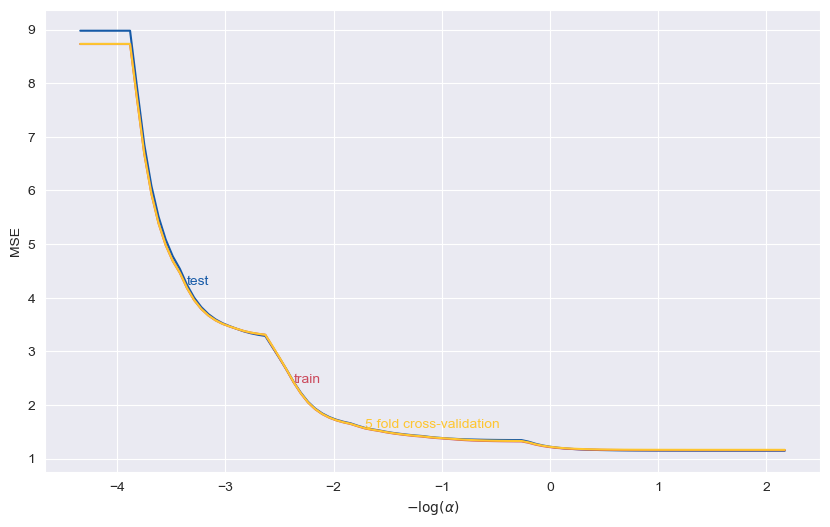

In [45]:
alphas = np.exp(np.linspace(10, -5, 100))
mse = pd.DataFrame([fit_and_report_mses(linear_model.Lasso(alpha=alpha, max_iter=50000),
                           X_train, X_test, y_train, y_test)
                    for alpha in alphas])
mse["log_alpha"] = -np.log10(alphas)
mse["cv"] = [-np.mean(cross_val_score(linear_model.Lasso(alpha=alpha, max_iter=50000),
                                  X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
          for alpha in alphas]

# create the plot
fig, ax = plt.subplots(figsize=(10,6))
mse.plot(x="log_alpha", y="mse_test", c=colors[0], ax=ax)
mse.plot(x="log_alpha", y="mse_train", c=colors[1], ax=ax)
mse.plot(x="log_alpha", y="cv", c=colors[2], ax=ax)
ax.set_xlabel(r"$-\log(\alpha)$")
ax.set_ylabel("MSE")
ax.get_legend().remove()
ax.annotate("test",(mse.log_alpha[15], mse.mse_test[15]),color=colors[0])
ax.annotate("train",(mse.log_alpha[30], mse.mse_train[30]),color=colors[1])
ax.annotate(f"{k} fold cross-validation", (mse.log_alpha[40], mse.cv[40]), color=colors[2])

#retrieve optimal alpha
lasso = linear_model.LassoCV(cv=5).fit(X_train,y_train)
neg_log_alpha = -np.log10(lasso.alpha_)
alpha = 10**(-1 * neg_log_alpha)
print(f"The optimal negative log alpha is {neg_log_alpha}, corresponding to an alpha of {alpha}")

# Check with Alex on alpha calculation. MSE coming out higher than before optimizing alpha so something is off here... No idea why it would be saying -0.8 is best. Tried zooming in and don't see anything 


In [46]:
# fit an updated lasso regression model with an alpha to optimize MSE
fuel_efficiency_lasso_model = linear_model.Lasso(alpha=7.39)
fuel_efficiency_lasso_model.fit(X_train, y_train)

mse_train = metrics.mean_squared_error(y_train, fuel_efficiency_lasso_model.predict(X_train))
mse_test = metrics.mean_squared_error(y_test, fuel_efficiency_lasso_model.predict(X_test))

print(f"The MSE on the training data is: {mse_train} and the MSE on the testing data is {mse_test}")

The MSE on the training data is: 1.3572979922157942 and the MSE on the testing data is 1.3694310136400254


As we did above, we'll also fit a regression tree and neural network.

In [47]:
# fitting a regression tree
depths = [5, 10, 15, 20, 25, 30]
for depth in depths:
    fuel_efficiency_fitted_tree = tree.DecisionTreeRegressor(max_depth=depth, random_state=123).fit(X_train,y_train)
    mse_train = metrics.mean_squared_error(y_train, fuel_efficiency_fitted_tree.predict(X_train))
    mse_test = metrics.mean_squared_error(y_test, fuel_efficiency_fitted_tree.predict(X_test))
    print(f"With depth {depth}, the MSE on the training data is: {mse_train} and the MSE on the testing data is {mse_test}")

With depth 5, the MSE on the training data is: 1.5801037971574687 and the MSE on the testing data is 1.6790342302529808
With depth 10, the MSE on the training data is: 0.6272940884923738 and the MSE on the testing data is 0.7941216006781947
With depth 15, the MSE on the training data is: 0.2806889035755023 and the MSE on the testing data is 0.5603232564199807
With depth 20, the MSE on the training data is: 0.20710464001966303 and the MSE on the testing data is 0.5637054059361509
With depth 25, the MSE on the training data is: 0.18755786963641724 and the MSE on the testing data is 0.5617101774094356
With depth 30, the MSE on the training data is: 0.1807443961126348 and the MSE on the testing data is 0.5666674417499687


With an optimal depth of 15, the MSE of our regression tree on the training data is 0.560. 

In [48]:
# fitting a neural network
fuel_efficiency_interaction_nn_scaled_model = pipeline.make_pipeline(
    preprocessing.StandardScaler(),
    neural_network.MLPRegressor((100, 100), max_iter=500, random_state=123)
)
 
fuel_efficiency_interaction_nn_scaled_model.fit(X_train, y_train.flatten())
mse_nn_train = metrics.mean_squared_error(y_train, fuel_efficiency_interaction_nn_scaled_model.predict(X_train))
mse_nn_test = metrics.mean_squared_error(y_test, fuel_efficiency_interaction_nn_scaled_model.predict(X_test))
print(f"The MSE on the training data is: {mse_nn_train} and the MSE on the testing data is {mse_nn_test}")

The MSE on the training data is: 0.40984045333940955 and the MSE on the testing data is 0.5040240835919703


As with the non-interactive predictors, the neural network for the ineractions with year yields the lowest MSE at 0.504. 

### 4c. Testing the Models

As further evaluation of our models, test it against some vehicles that have yet to be released:
- 2024 Ford F-150 (a truck) with a 3.5L V6 gasoline engine and 10 speed automatic transmission, that gets an estimated 11.7 L/100km
- 2024 Honda Civic (a car) with a 2.0L 4-Cylinder gasoline engine and continuously variable transmission, that gets an estimated 6.5 L/100km
- 2024 Mazda CX-90 (a SUV) with a 3.3L V6 premium gasoline engine and 8 speed automatic transmission, that gets an estimated 9.4 L/100km
- 2024 Kia Carnival (a van) with a 3.5L V6 gasoline engine and 8 speed automatic transmission, that gets an estimated 10.7 L/100km
- 2024 Chevrolet Trax (a SUV) with a 1.2L 3-Cylinder gasoline engine and a 6 speed automatic transmission, that gets an estimated 7.8 L/100 km
- 2024 Hyundai Elantra (a car) with a 2.0L 4-Cylinder gasoline engine and continuously variable transmission, that gets an estimated 6.2 L/100km
- 2024 Chevrolet Silverado 1500 (a truck) with a 3.0L 6-Cylinder diesel engine and a 10 speed automatic transmission, that gets an estimated 9.0 L/100km

Most 2024 models aren't officially published, so this data was obtained from the following sources
- https://www.edmunds.com/ford/f-150/2024/#:~:text=EPA%2Destimated%20fuel%20economy%20is,V8%2Dequipped%20Silverado%20or%20Ram
- https://www.caranddriver.com/honda/civic
- https://www.caranddriver.com/news/a42789780/2024-mazda-cx-90-power-mpg-specs/
- https://driving.ca/kia/carnival/
- https://www.caranddriver.com/chevrolet/trax
- https://www.caranddriver.com/hyundai/elantra
- https://www.motortrend.com/cars/chevrolet/silverado-1500/2024/


In [49]:
# creating the dataset
data = {"model_year": [2024, 2024, 2024, 2024, 2024, 2024, 2024],
                 "make": ["Ford", "Honda", "Mazda", "Kia", "Chevrolet", "Hyundai", "Chevrolet"],
                 "model": ["F-150", "Civic", "CX-90", "Carnival", "Trax", "Elantra", "Silverado 1500"],
                 "vehicle_class": ["Truck", "Car", "SUV", "Van", "SUV", "Car", "Truck"],
                 "fuel_type": ["Regular Gasoline", "Regular Gasoline", "Premium Gasoline", "Regular Gasoline", 
                               "Regular Gasoline", "Regular Gasoline", "Diesel"],
                 "engine_size_L": [3.5, 2, 3.3, 3.5, 1.2, 2.0, 3.0],
                 "cylinders": [6.0, 4.0, 6.0, 6.0, 3.0, 4.0, 6.0],
                 "transmission_type": ["Automatic", "Continuously Variable", "Automatic", "Automatic", 
                                       "Automatic", "Continuously Variable", "Automatic"],
                 "transmission_gears": [10, 1, 8, 8, 6, 1, 10],
                 "comb_lpkm": [11.7, 6.5, 9.4, 10.7, 7.8, 6.2, 9.0]}

vehicles_to_predict = pd.DataFrame(data)
full_dataset_with_predictions = pd.concat([full_dataset, vehicles_to_predict])
full_dataset_with_predictions.reset_index(drop=True,inplace=True)
full_dataset_with_predictions.loc[full_dataset_with_predictions.index[-7]:full_dataset_with_predictions.index[-1],:]

model_year       make           model vehicle_class         fuel_type  \
18938        2024       Ford           F-150         Truck  Regular Gasoline   
18939        2024      Honda           Civic           Car  Regular Gasoline   
18940        2024      Mazda           CX-90           SUV  Premium Gasoline   
18941        2024        Kia        Carnival           Van  Regular Gasoline   
18942        2024  Chevrolet            Trax           SUV  Regular Gasoline   
18943        2024    Hyundai         Elantra           Car  Regular Gasoline   
18944        2024  Chevrolet  Silverado 1500         Truck            Diesel   

       engine_size_L  cylinders      transmission_type  transmission_gears  \
18938            3.5        6.0              Automatic                  10   
18939            2.0        4.0  Continuously Variable                   1   
18940            3.3        6.0              Automatic                   8   
18941            3.5        6.0              Automatic                   8   
18942            1.2        3.0              Automatic                   6   
18943            2.0        4.0  Continuously Variable                   1   
18944            3.0        6.0              Automatic                  10   

       comb_lpkm  
18938       11.7  
18939        6.5  
18940        9.4  
18941       10.7  
18942        7.8  
18943        6.2  
18944        9.0

We'll use the neural network on the non-interactive predictors, as it yielded the lowest MSE on our testing data above. 

In [50]:
# using the neural network model with no interaction
y, X = patsy.dmatrices("comb_lpkm ~ model_year + C(make) + C(vehicle_class) + " +
                       "C(fuel_type) + engine_size_L + cylinders + C(transmission_type) + " +
                        "transmission_gears", full_dataset_with_predictions, return_type='matrix')
test_vehicles = X[-7:,:]
predicted_efficiency = fuel_efficiency_nn_scaled_model.predict(test_vehicles)
predicted_efficiency = predicted_efficiency.flatten()
actual_efficiency = y[-7:]
actual_efficiency = actual_efficiency.flatten()
percent_error = abs(predicted_efficiency-actual_efficiency)/actual_efficiency*100
vehicle_names = ("2024 Ford F150", "2024 Honda Civic", "2024 Mazda CX-90", "2024 Kia Carnival", 
                 "2024 Chevrolet Trax", "2024 Hyundai Elantra", "2024 Chevrolet Silverado 1500")
predicted = pd.Series(dict(zip(vehicle_names, predicted_efficiency)))
actual = pd.Series(dict(zip(vehicle_names, actual_efficiency)))
difference = pd.Series(dict(zip(vehicle_names, percent_error)))
result = pd.DataFrame(dict(predicted_efficiency=predicted, actual_efficiency=actual, percent_difference=difference))
result

predicted_efficiency  actual_efficiency  \
2024 Ford F150                            11.596046               11.7   
2024 Honda Civic                           7.028889                6.5   
2024 Mazda CX-90                          11.074998                9.4   
2024 Kia Carnival                         11.634208               10.7   
2024 Chevrolet Trax                        7.644308                7.8   
2024 Hyundai Elantra                       6.613821                6.2   
2024 Chevrolet Silverado 1500              9.778465                9.0   

                               percent_difference  
2024 Ford F150                           0.888496  
2024 Honda Civic                         8.136759  
2024 Mazda CX-90                        17.819131  
2024 Kia Carnival                        8.730918  
2024 Chevrolet Trax                      1.996049  
2024 Hyundai Elantra                     6.674524  
2024 Chevrolet Silverado 1500            8.649611

Overall the model predicts the fuel economy of these unreleased vehicles within 10% of the actual value in 6/7 cases, however overpredicts the 2024 Mazda CX-90 by almost 18%. 

The model may have a bias towards overpredicting fuel economy of future models, as the predicted efficiency was above the actual efficiency is 6/7 cases, although the sample size is too small to draw strong conclusions. 

# 5. R&D Spending

While the model above does a great job at predicting vehicle efficiency, it also requires a great deal of information about the vehicle itself in order to make that prediction. It may, however, be useful to be able to predict the efficiency of vehicles based on historical data alone. 

One potential solution involves leveraging a company's research and development expenses to predict future fuel efficiency. Since efficiency improvements require significant investment in R&D, it follows that incorporating data on previous efficiency levels and R&D expenses could predict future efficiency levels. If past year's R&D expenses are a good predictor of future efficiency, a model could then use the company's forcasted spending alongside present day efficiency to predict the improvements in efficiency of next year's model. That way, consumers can determine the efficiency increase they can expect by waiting a year to purchase next year's model.

We will start by obtaining R&D expense data from annual financial reports. To do so, we can use the tabula library to parse tables from the PDF files, then locate and extract the R&D expenses. We've decided to begin with Toyota since they are a prominent manufacturer across all vehicle classes, providing a versatile source of data for our analysis:

In [51]:
def retrieve_toyota_rnd_exp(url):
    """
    Parse the RnD Expense for each year from the given url (pdf file of Toyota FY financial results)
    Returns a dict with years and RnD expense (billions of yen).
    
    The parser was designed to handle variations in structure and language that exist among the different 
    formats of the PDF files.
    """
    
    rnd_regex = re.compile(r"(?:R&D|Research & Development)", flags=re.IGNORECASE)

    # extract all tables from the pdf
    all_dfs = tabula.read_pdf(url, pages='all', multiple_tables=True)
    
    def locate_rnd_table(all_dfs):
        """Locate the DataFrame containing the R&D expense data from the list of parsed dfs"""
        for df in all_dfs:
            string_cols = df.select_dtypes(include=['object']).columns
            if df[string_cols].apply(lambda col: col.str.contains(rnd_regex, na=False)).any().any():
                RnD_df = df
                RnD_df.reset_index(drop=True, inplace=True)
                break
        RnD_df = RnD_df.set_index(RnD_df.columns[0])
        return RnD_df
    
    RnD_df = locate_rnd_table(all_dfs)
    
    def locate_annual_rnd_columns(RnD_df):
        """Locate the columns containing the R&D expense data from the given DataFrame"""
        # remove forecast/prospects column
        RnD_df = RnD_df.drop(columns=[col for col in RnD_df.columns if 'Forecast' in col or 'Prospects' in col])
        RnD_df = RnD_df.drop(columns=[col for col in RnD_df.columns if 
                                      RnD_df.applymap(lambda x: 'Forecast' in str(x) or 
                                                      'Prospects' in str(x))[col].any()])

        # since the df has unlabeled quarterly and annual data, by assumption - keeping only the two columns 
        #   with the largest R&D expense values will give us the annual columns
        rnd_row = RnD_df.loc[RnD_df.index.str.contains(rnd_regex, na=False)].dropna(axis=1)
        has_spaces = rnd_row.applymap(lambda x: ' ' in str(x))
        drop_cols = has_spaces.any(axis=0)
        rnd_row = rnd_row.loc[:, ~drop_cols]
        rnd_row = rnd_row.replace('[^0-9\.]+', '', regex=True).astype(float)
        largest_val_cols = rnd_row.apply(lambda row: row.nlargest(2).index.tolist(), axis=1)
        selected_cols = [col for col in RnD_df.columns if col in largest_val_cols[0]]
        filtered_RnD_df = RnD_df.loc[:, selected_cols]
        
        return filtered_RnD_df

    filtered_RnD_df = locate_annual_rnd_columns(RnD_df)
    
    def find_rnd_years(filtered_RnD_df, url):
        """Get the years corresponding to the R&D data from the url, then set them as the column names in the df"""
        year2 = int(re.findall(r'20\d{2}', url)[0])
        year1 = year2-1
        filtered_RnD_df.columns = [year1, year2]

        return filtered_RnD_df

    find_rnd_years(filtered_RnD_df, url)

    def create_dict(filtered_RnD_df):
        """Create a dict with the years as keys, and corresponding R&D expense as values"""
        toyota_rnd_expenses = filtered_RnD_df.loc[filtered_RnD_df.index.str.contains(rnd_regex).fillna(False)]
        toyota_rnd_dict = toyota_rnd_expenses.iloc[0].to_dict()
        for key, value in toyota_rnd_dict.items():
            toyota_rnd_dict[key] = float(value.replace(",",""))
        
        return toyota_rnd_dict
    
    toyota_rnd_dict = create_dict(filtered_RnD_df)
    
    return toyota_rnd_dict

In [52]:
toyota_rnd_21_22 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/2022_4q_summary_en.pdf")
toyota_rnd_19_20 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/2020_4q_summary_en.pdf")
toyota_rnd_17_18 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_9_2018_summary.pdf")
toyota_rnd_15_16 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_11_2016_consolidated.pdf")
toyota_rnd_13_14 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_8_2014_consolidated.pdf")
toyota_rnd_11_12 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_9_2012_consolidated.pdf")
toyota_rnd_09_10 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_11_2010_consolidated.pdf")
toyota_rnd_07_08 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_8_2008_consolidated.pdf")
toyota_rnd_05_06 = retrieve_toyota_rnd_exp('https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_10_2006_consolidated.pdf')
toyota_rnd_03_04 = retrieve_toyota_rnd_exp('https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_11_2004_consolidated.pdf')
toyota_rnd_01_02 = retrieve_toyota_rnd_exp('https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_13_2002_Highlights_Consolidated.pdf')
toyota_rnd_00_01 = retrieve_toyota_rnd_exp('https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_16_2001_Highlights_Unconsolidated.pdf')

Got stderr: Apr. 14, 2023 5:16:17 P.M. org.apache.fontbox.ttf.CmapSubtable processSubtype14
Apr. 14, 2023 5:16:18 P.M. org.apache.fontbox.ttf.CmapSubtable processSubtype14
Apr. 14, 2023 5:16:19 P.M. org.apache.fontbox.ttf.CmapSubtable processSubtype14
Apr. 14, 2023 5:16:19 P.M. org.apache.fontbox.ttf.CmapSubtable processSubtype14
Apr. 14, 2023 5:16:19 P.M. org.apache.fontbox.ttf.CmapSubtable processSubtype14

Got stderr: Apr. 14, 2023 5:16:27 P.M. org.apache.fontbox.ttf.CmapSubtable processSubtype14
Apr. 14, 2023 5:16:28 P.M. org.apache.fontbox.ttf.CmapSubtable processSubtype14
Apr. 14, 2023 5:16:29 P.M. org.apache.fontbox.ttf.CmapSubtable processSubtype14
Apr. 14, 2023 5:16:30 P.M. org.apache.fontbox.ttf.CmapSubtable processSubtype14
Apr. 14, 2023 5:16:30 P.M. org.apache.fontbox.ttf.CmapSubtable processSubtype14

Got stderr: Apr. 14, 2023 5:17:17 P.M. org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
Apr. 14, 2023 5:17:18 P.M. org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
Ap

In [53]:
rnd_dicts = [toyota_rnd_00_01, toyota_rnd_01_02, toyota_rnd_03_04, toyota_rnd_05_06, toyota_rnd_07_08,
            toyota_rnd_09_10, toyota_rnd_11_12, toyota_rnd_13_14, toyota_rnd_15_16, toyota_rnd_17_18,
            toyota_rnd_19_20, toyota_rnd_21_22]
toyota_rnd = {}
for dict in rnd_dicts:
    toyota_rnd.update(dict)
print(toyota_rnd)

{2000: 402.8, 2001: 479.9, 2002: 592.5, 2003: 668.4, 2004: 682.2, 2005: 755.1, 2006: 812.6, 2007: 890.7, 2008: 958.8, 2009: 904.0, 2010: 725.3, 2011: 730.3, 2012: 779.8, 2013: 807.4, 2014: 910.5, 2015: 1004.5, 2016: 1055.6, 2017: 1037.5, 2018: 1064.2, 2019: 1048.8, 2020: 1110.3, 2021: 1090.4, 2022: 1124.2}


Since we want to use the previous year's R&D expense data to predict the subsequent year's efficiency, we'll need to shift the R&D expense data to align the columns. 

In [54]:
aligned_toyota_rnd = {key+1: value for key, value in toyota_rnd.items()}
print(aligned_toyota_rnd)

{2001: 402.8, 2002: 479.9, 2003: 592.5, 2004: 668.4, 2005: 682.2, 2006: 755.1, 2007: 812.6, 2008: 890.7, 2009: 958.8, 2010: 904.0, 2011: 725.3, 2012: 730.3, 2013: 779.8, 2014: 807.4, 2015: 910.5, 2016: 1004.5, 2017: 1055.6, 2018: 1037.5, 2019: 1064.2, 2020: 1048.8, 2021: 1110.3, 2022: 1090.4, 2023: 1124.2}


Next we'll examine the relationship between the vehicle information and rnd expense data. The goal is to use the previous years vehicle information and Toyota's R&D expense to try and predict the current year's combined fuel economy. 

We start by adding the parsed R&D expense data to the vehicle information, and visualize the data. We'll separate the vehicles by vehicle class, since oftentimes consumers will enter the market with the need for a specific vehicle class (ie. a construction worker might need a truck for their job, or a family with children may need an SUV...), and use the average fuel economy of each year for each class to build our model. 

In [55]:
toyota_dataset = full_dataset[full_dataset['make'] == 'Toyota'][['model_year', 'vehicle_class', 'comb_lpkm']].sort_values('model_year')
toyota_dataset['rnd_expense'] = toyota_dataset['model_year'].map(aligned_toyota_rnd)
toyota_dataset

model_year vehicle_class  comb_lpkm  rnd_expense
16370        2000         Truck       15.8          NaN
16354        2000           SUV       11.2          NaN
16355        2000           SUV       10.2          NaN
16356        2000           SUV       10.1          NaN
16357        2000           SUV       10.9          NaN
...           ...           ...        ...          ...
626          2023           SUV        6.7       1124.2
625          2023           SUV        6.7       1124.2
624          2023           SUV        9.9       1124.2
633          2023           SUV       11.7       1124.2
600          2023           SUV       13.8       1124.2

[1046 rows x 4 columns]

In [56]:
averaged_toyota_dataset = toyota_dataset.groupby(['model_year', 'vehicle_class']).mean().reset_index()

fig = px.scatter_3d(averaged_toyota_dataset, 
                    x='model_year', 
                    y='rnd_expense', 
                    z='comb_lpkm',
                    color='vehicle_class')
fig.update_layout(title='The Relationship of R&D Expense Over Time on Average Toyota Fuel Economy',
                  scene={'xaxis_title':'Model Year',
                         'yaxis_title':'R&D Expense (billions of yen)',
                         'zaxis_title':'Combined Fuel Economy'},
                  legend_title='Vehicle Class',
                  width=1000, height=800)
fig.show()

One thing that immediately sticks out from the plot is the precipitous drop in fuel economy of Toyota vans in 2021. In 2021, Toyota vans switched to continuously variable transmission, which led to a significant increase in efficiency. We will continue the analysis using the whole range of van data (as using only the two years since the switch in transmission type is likely to be inaccurate) with the note that this regression is likely to overpredict fuel economy for upcoming models of vans. 

Now that we have a plot, we can create a regression plane for each vehicle class, and add it to the visualization.

First we'll want to check if the inclusion of R&D expense information is helping the model. We do so by comparing the MSE both with and without the R&D expense data included. 

In [57]:
toyota_cars = toyota_dataset[toyota_dataset['vehicle_class'] == 'Car'].copy()
toyota_SUVs = toyota_dataset[toyota_dataset['vehicle_class'] == 'SUV'].copy()
toyota_trucks = toyota_dataset[toyota_dataset['vehicle_class'] == 'Truck'].copy()
toyota_vans = toyota_dataset[toyota_dataset['vehicle_class'] == 'Van'].copy()

toyota_subsets = [toyota_cars, toyota_SUVs, toyota_trucks, toyota_vans]

In [58]:
regression_dict = {}

for subset in toyota_subsets:
    make = subset['vehicle_class'].iloc[0]
    length = len(subset)
    subset.dropna(inplace=True)
    X_year_alone = subset[['model_year']].copy()
    y = subset['comb_lpkm']
    lr_model_year_alone = linear_model.LinearRegression()
    lr_model_year_alone.fit(X_year_alone, y)

    mse_year_alone = metrics.mean_squared_error(y, lr_model_year_alone.predict(X_year_alone))
    
    print(f"Model for {make} with year alone: mse = {mse_year_alone}")
    
    lr_model_with_rnd = linear_model.LinearRegression()
    X_with_rnd = subset[['model_year', 'rnd_expense']].copy()
    lr_model_with_rnd.fit(X_with_rnd, y)
    
    beta_0 = lr_model_with_rnd.intercept_
    beta_1 = lr_model_with_rnd.coef_[0]
    beta_2 = lr_model_with_rnd.coef_[1]
    
    mse_with_rnd = metrics.mean_squared_error(y, lr_model_with_rnd.predict(X_with_rnd))
    
    print(f"Model for {make} with R&D expense: mse = {mse_with_rnd}")

Model for Car with year alone: mse = 2.5964739135895107
Model for Car with R&D expense: mse = 2.5940816695477054
Model for SUV with year alone: mse = 5.718884995756828
Model for SUV with R&D expense: mse = 5.696772116895329
Model for Truck with year alone: mse = 3.0011751162841036
Model for Truck with R&D expense: mse = 2.9982356709670737
Model for Van with year alone: mse = 1.920415294633803
Model for Van with R&D expense: mse = 1.878675296437409


Unsurprisingly, for all vehicle classes the MSE is slightly lower for the regression including the R&D expense data. As such, going forward we will include the R&D expense data in our model. 

In [59]:
regression_dict = {}

for subset in toyota_subsets:
    make = subset['vehicle_class'].iloc[0]
    length = len(subset)
    subset.dropna(inplace=True)
    lr_model_with_rnd = linear_model.LinearRegression()
    X_with_rnd = subset[['model_year', 'rnd_expense']].copy()
    y = subset['comb_lpkm']

    lr_model_with_rnd.fit(X_with_rnd, y)
    
    beta_0 = lr_model_with_rnd.intercept_
    beta_1 = lr_model_with_rnd.coef_[0]
    beta_2 = lr_model_with_rnd.coef_[1]
    
    regression_dict.update({subset['vehicle_class'].iloc[0]:{'beta_0':beta_0,
                      'beta_1':beta_1,
                      'beta_2':beta_2}})
        
    print(f"Model for {make}: \n Combined Fuel Economy = {beta_0} + {beta_1} * Model Year + {beta_2}" + 
          f" * R&D Expense")

Model for Car: 
 Combined Fuel Economy = 278.39182523184854 + -0.13458233853324722 * Model Year + 0.0006109750081191417 * R&D Expense
Model for SUV: 
 Combined Fuel Economy = 538.0924233556233 + -0.26246791087955135 * Model Year + 0.0017471730154143537 * R&D Expense
Model for Truck: 
 Combined Fuel Economy = 181.6332019630639 + -0.08382960933020638 * Model Year + 0.0006040939383946424 * R&D Expense
Model for Van: 
 Combined Fuel Economy = 588.9863851161135 + -0.28820117563043923 * Model Year + 0.0026092105678520295 * R&D Expense


We can use the best fit equations to plot regression lines for each vehicle class.

In [60]:
averaged_toyota_dataset = toyota_dataset.groupby(['model_year', 'vehicle_class']).mean().reset_index()

years = list(aligned_toyota_rnd.keys())
years = np.array([int(year) for year in years])
rnd_exp = list(aligned_toyota_rnd.values())
rnd_exp = np.array([float(exp) for exp in rnd_exp])

pred_cars = np.array([])
pred_SUVs = np.array([])
pred_trucks = np.array([])
pred_vans = np.array([])


for year, expense in zip(years, rnd_exp):
        pred_cars = np.append(pred_cars, regression_dict['Car']['beta_0'] + regression_dict['Car']['beta_1']*year + regression_dict['Car']['beta_2']*expense)
        pred_SUVs = np.append(pred_SUVs, regression_dict['SUV']['beta_0'] + regression_dict['SUV']['beta_1']*year + regression_dict['SUV']['beta_2']*expense)
        pred_trucks = np.append(pred_trucks, regression_dict['Truck']['beta_0'] + regression_dict['Truck']['beta_1']*year + regression_dict['Truck']['beta_2']*expense)
        pred_vans = np.append(pred_vans, regression_dict['Van']['beta_0'] + regression_dict['Van']['beta_1']*year + regression_dict['Van']['beta_2']*expense)

fig.add_trace(go.Scatter3d(x=years, y=rnd_exp, z=pred_cars, mode='lines', name = "Car regression", 
                           line={'color':'blue'}))
fig.add_trace(go.Scatter3d(x=years, y=rnd_exp, z=pred_SUVs, mode='lines', name = "SUV regression", 
                           line={'color':'red'}))
fig.add_trace(go.Scatter3d(x=years, y=rnd_exp, z=pred_trucks, mode='lines', name = "Truck regression", 
                           line={'color':'green'}))
fig.add_trace(go.Scatter3d(x=years, y=rnd_exp, z=pred_vans, mode='lines', name = "Van regression", 
                           line={'color':'purple'}))

fig.show()

Per Toyota's 2022 full-year financial summary, they forecast an R&D Expense of 1130.0 billion yen in 2023. According to our regression model, we can calculate the 2023 expected average fuel economies for each vehicle class.

In [61]:
predicted_car_economy = regression_dict['Car']['beta_0'] + regression_dict['Car']['beta_1']*2023 + regression_dict['Car']['beta_2']*1130
predicted_SUV_economy = regression_dict['SUV']['beta_0'] + regression_dict['SUV']['beta_1']*2023 + regression_dict['SUV']['beta_2']*1130
predicted_truck_economy = regression_dict['Truck']['beta_0'] + regression_dict['Truck']['beta_1']*2023 + regression_dict['Truck']['beta_2']*1130
predicted_van_economy = regression_dict['Van']['beta_0'] + regression_dict['Van']['beta_1']*2023 + regression_dict['Van']['beta_2']*1130


print(f"The predicted combined fuel economy of the average 2024 Toyota car is: {predicted_car_economy}")
print(f"The predicted combined fuel economy of the average 2024 Toyota SUV is: {predicted_SUV_economy}")
print(f"The predicted combined fuel economy of the average 2024 Toyota truck is: {predicted_truck_economy}")
print(f"The predicted combined fuel economy of the average 2024 Toyota van is: {predicted_van_economy}")

The predicted combined fuel economy of the average 2024 Toyota car is: 6.822156138264074
The predicted combined fuel economy of the average 2024 Toyota SUV is: 9.09414515370909
The predicted combined fuel economy of the average 2024 Toyota truck is: 12.728528438442343
The predicted combined fuel economy of the average 2024 Toyota van is: 8.903814757407726


# 6. Conclusions

Overall, it's clear that in general fuel economy of vehicles is decreasing over time. Alongside that, we found several factors to be correlated with increased fuel efficiency, including the make, vehicle type, fuel type, engine size, number of cylinders, and transmission type, while the number of transmission gears appeared to have no correlation. 

We were also able to find an interaction between the model year and a vehicle's make, vehicle type, fuel type, and transmission type for years between 2000-2023. 
- The most improved makes of vehicles include Buick, Jeep, Kia, Lexus, Maxda, Nissan, Toyota and Volvo. 
- SUVs and Vans have improved their efficiency by much more than cars and trucks
- Regular gasoline vehicles have had a lower fuel economy than premium gasoline vehicles since 2005, and have improved their efficiency more over the course of the range of dates
- CVT vehicles are the most efficient transmission type, and have imrpoved their efficiency the most since their adoption in 2002. 

We were also able to fit standard regression, lasso, regression tree, and neural network models to predict fuel efficiency using each predictor individually, and their interation with time. In both, the neural network was found to be the most accurate predictor. It was also able to predict the efficiency of unreleased 2024 vehicle models with moderate success. 

We were also aboe to import Toyota's R&D expenses from their full year annual reports, and use that alongside the model year to model a regression to predict the efficiency of future vehicles. 

# Limiations and Future Research section or nah? Could also just add a comment at the bottom of conclusions section for future research.

# References section necessary if we link our sources throughout?